# Evaluating joint fine-tuning

### Stratified by cell types

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from architecture_batchNorm_momentum import *
from finetuning_architecture import * 
from data_augmentation import *
from data_utils_finetuning import *
from data_utils import *
from evaluate import *

from gastrulation_correlation_tss import *

import pickle
import gc
import os

#import tensorflow as tf

/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-30 12:44:39.811592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
atac=True
rna=True

odcf = False
if odcf:
    data_dir = "/omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/"
else:
    data_dir = "/data/mikulik/mnt/gcs_basenj/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using: cuda:0
Number of GPUs available: 2


# Model trained jointly on RNA & ATAC 

In [4]:
# initialize model for finetuning
tracks = 37 + 35 # just atac tracks
# tracks = 72 # both rna and atac tracks
pretrained_model = "basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint"
num_dilated_conv = 11
num_conv = 6
conv_target_channels = 768
dilation_rate_init = 1
bn_momentum = .9
dilation_rate_mult = 1.5
experiments_human = 5313
experiments_mouse = 1643

model = FineTuning(data_dir=os.path.join(data_dir, "basenji_output", "clean_slate"),
                            model_name=pretrained_model, 
                            tracks = tracks,                
                            num_conv=num_conv,
                            num_dilated_conv=num_dilated_conv,
                            conv_target_channels=conv_target_channels, 
                            bn_momentum=0.9, 
                            dilation_rate_init=dilation_rate_init, 
                            dilation_rate_mult=1.5, 
                            experiments_human=5313, 
                            experiments_mouse=1643).to(device)


In [5]:
print(f"Number of parameters of fine-tuned model jointly trained on RNA and ATAC-seq: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters of fine-tuned model jointly trained on RNA and ATAC-seq: 32729640


In [6]:
corr_save_atac = {}
corr_save_rna = {}
save=False
if save:                            
    for file in os.listdir(os.path.join(data_dir, "finetune_output", "joint")):
        if file.startswith("joint") & file.endswith("model_validation_checkpoint.pt"):
            print(file)
            # load fine-tuned model
            model.load_state_dict(torch.load(os.path.join(data_dir, "finetune_output", "joint", f"{file}")))#, map_location=torch.device("cpu")))#, strict=False)
            model.to(device)

            # compute correlations across positions separately for RNA and ATAC-seq
            atac_corr, rna_corr = rna_atac_correlation(data_dir, model, device=device, subset="test", max_steps=2017, atac_channels=35, rna_channels=37)
            print(f"ATAC mean: {atac_corr.mean()}, RNA mean: {rna_corr.mean()}")

            # add correlation vector to dictionary
            corr_save_atac[file] = atac_corr
            corr_save_rna[file] = rna_corr
    # save dictionaries
    with open(os.path.join(data_dir, "finetune_output", "join_training_atac_corr.pkl"), "wb") as f:
        pickle.dump(corr_save_atac, f)
    with open(os.path.join(data_dir, "finetune_output", "join_training_rna_corr.pkl"), "wb") as f:
        pickle.dump(corr_save_rna, f)
        
else: 
    with open(os.path.join(data_dir, "finetune_output", "join_training_atac_corr.pkl"), "rb") as f:
        corr_save_atac = pickle.load(f)
    with open(os.path.join(data_dir, "finetune_output", "join_training_rna_corr.pkl"), "rb") as f:
        corr_save_rna = pickle.load(f)

### Correlation across positions for ATAC-seq 

In [7]:
# load target annotations
atac_tar = pd.read_csv(os.path.join(data_dir, "atac_targets.txt"),sep=",", index_col=0, header=0)


In [8]:
lr_dict = {}
for key, value in corr_save_atac.items():
    name = key.split("joint_")[1].split("_model_validation_checkpoint")[0]
    lr_dict[name] = float(value.mean())
    atac_tar[f"{name}"] = value


In [9]:
# plot correlation barplots per cell type for different hyperparameter settings 
#for key, value in corr_save_atac.items():
#    name = key.split("joint_")[1].split("_model_validation_checkpoint")[0]
#
#    sns.barplot(data=atac_tar, x="celltype", y=f"{name}_corr", palette=atac_tar["color"])#, color="blue")
#    plt.title(f"{name}, µ = {atac_tar[name].mean():.3f}")
#    plt.xlabel("cell type")
#    plt.ylabel("correlation across positions")
#    plt.xticks(rotation=90)
#    plt.show()




Comparing different hyperparameter settings and the average correlation across postions for each model.

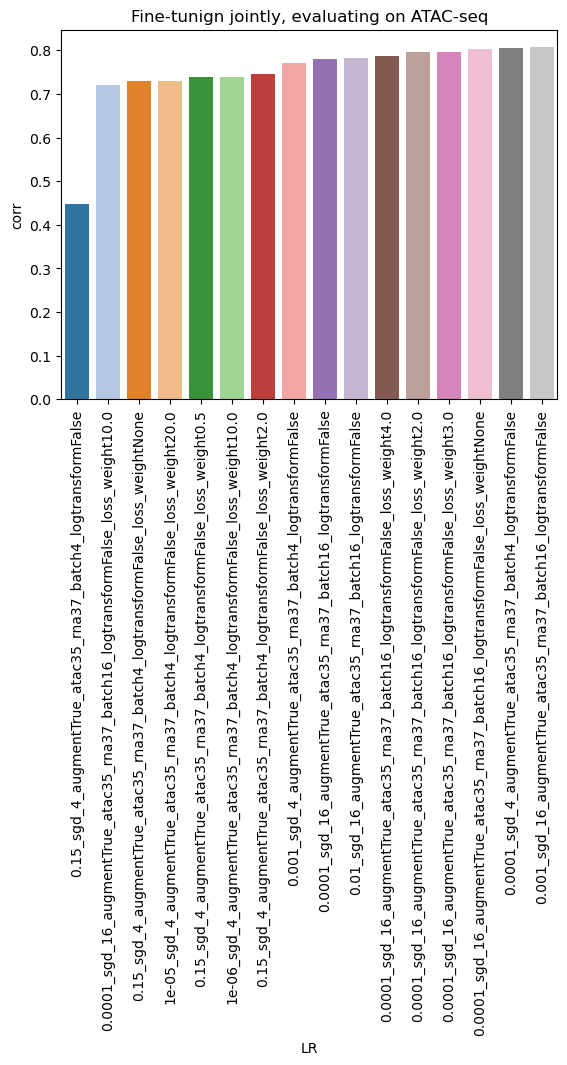

In [10]:
plot_parameter_comparison(lr_dict, title="Fine-tunign jointly, evaluating on ATAC-seq", save_pdf=None)


What is the effect of the number of cell types on the correlation across positions between observed and predicted ATAC-seq signal after joint fine-tuning?

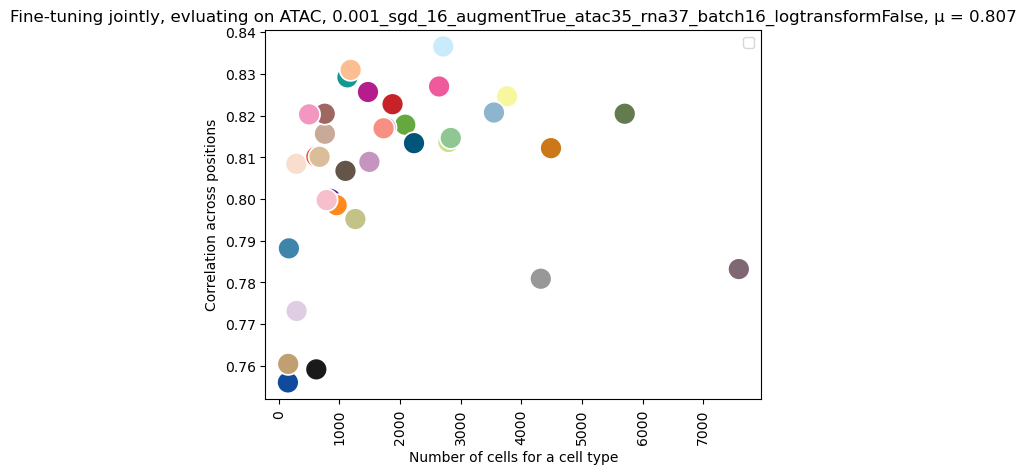

In [11]:
save=False
if save:
    corr_vs_n_cells(atac_tar, model="0.001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse", 
            title="Fine-tuning jointly, evluating on ATAC", ylabel="Correlation across positions", 
            save_pdf=os.path.join(data_dir, "plots/finetune_atac/",  'best_joint_finetune_atac_corr_n_scatter.pdf'))
else:
    corr_vs_n_cells(atac_tar, model="0.001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse", 
            title="Fine-tuning jointly, evluating on ATAC", ylabel="Correlation across positions", save_pdf=None)


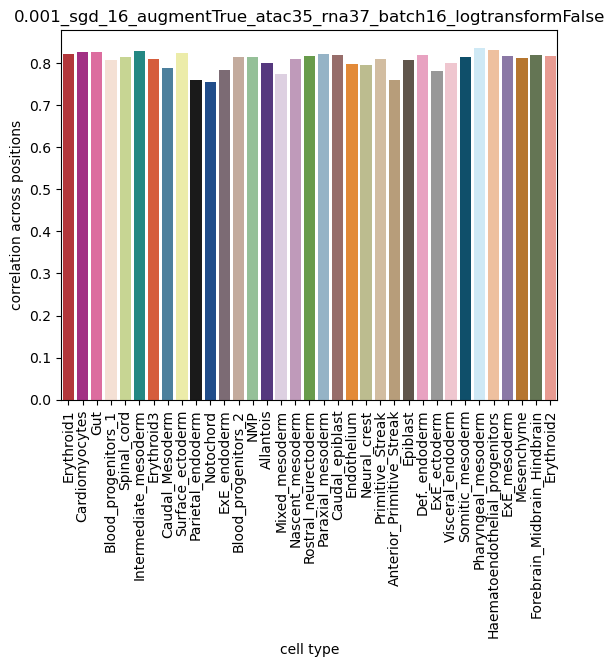

In [12]:
#same as above but as a barplot
sns.barplot(atac_tar, x="celltype", y="0.001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse", palette=atac_tar["color"])
plt.title(f"0.001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse")
plt.xlabel("cell type")
plt.ylabel("correlation across positions")
plt.xticks(rotation=90)
if save:
    plt.savefig(os.path.join(data_dir, "plots/finetune_atac/",  'best_joint_finetune_atac_corr_n.pdf'), format='pdf')
plt.show()

### Compare joint finetunign with just finetuning on ATAC:

In [13]:
with open(os.path.join(data_dir, "finetune_output", "atac_corr_lr_comp.pkl"), "rb") as f:
    corr_save = pickle.load(f)


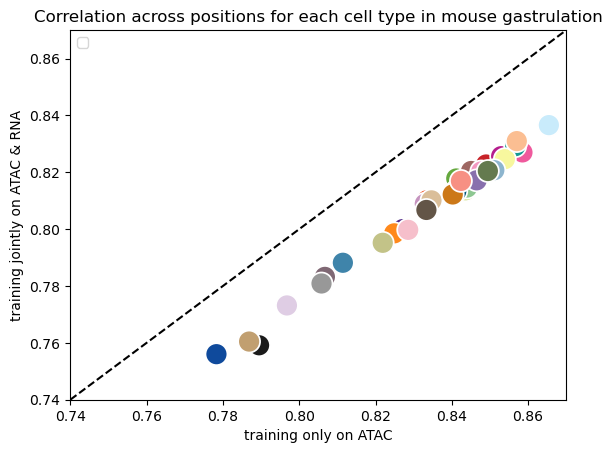

In [14]:
# select the two best hyperparameter settings for both joint and atac finetuning
atac_train = corr_save["finetune_test_0.0001_sgd_4_augmentFalse_model_validation_checkpoint.pt"]
joint_train = corr_save_atac["joint_0.001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_model_validation_checkpoint.pt"]
# append them to target df
atac_tar["atac_train"] = atac_train
atac_tar["joint_train"] = joint_train


unique_colors = atac_tar['color'].unique()
# Create a custom color palette
custom_palette = sns.color_palette(unique_colors)
# Set the custom palette
sns.set_palette = custom_palette

# Create a Seaborn plot using the custom palette
sns.scatterplot(atac_tar, x='atac_train', y='joint_train', hue="celltype",palette=custom_palette, s=250)#, alpha=0.5)
sns.lineplot(x=[0.74,0.87], y=[0.74,0.87], color="black", linestyle='--')
plt.legend([]) 
plt.xlabel("training only on ATAC")
plt.ylabel("training jointly on ATAC & RNA")
plt.title("Correlation across positions for each cell type in mouse gastrulation")
plt.ylim([0.74,0.87])
plt.xlim([0.74,0.87])
plt.savefig(os.path.join(data_dir, "plots/finetune_atac/",  'atac_joint_finetune_comp.pdf'), format='pdf')
plt.show()

## RNA average correlation across positions

In [15]:
# read in mouse gastrulation RNA-seq targets
rna_tar =pd.read_csv(os.path.join(data_dir, "rna_targets_gastrulation_df.txt"),sep=",", index_col=0, header=0)


In [16]:
lr_dict = {}
for key, value in corr_save_rna.items():
    name = key.split("joint_")[1].split("_model_validation_checkpoint")[0]
    lr_dict[name] = float(value.mean())
    rna_tar[f"{name}"] = value

    #if plot:
    #    sns.barplot(data=rna_tar, x="celltype", y=f"{name}_corr", palette=rna_tar["color"])#, color="blue")
    #    plt.title(f"{key}, µ = {value.mean():.3f}")
    #    plt.xlabel("cell type")
    #    plt.ylabel("correlation across positions")
    #    plt.xticks(rotation=90)
    #    plt.show()




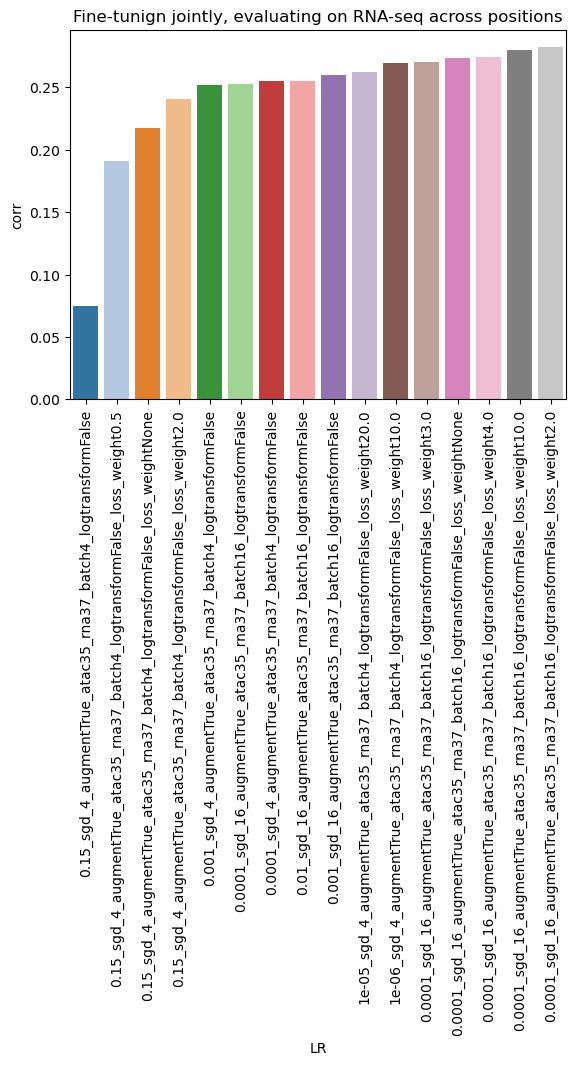

In [17]:
plot_parameter_comparison(lr_dict, title="Fine-tunign jointly, evaluating on RNA-seq across positions", save_pdf=None)


#  Correlation at TSS

In [28]:
# read in mouse gastrulation RNA-seq targets
rna_tar =pd.read_csv(os.path.join(data_dir, "rna_targets_gastrulation_df.txt"),sep=",", index_col=0, header=0)


In [29]:
overlap = pd.read_csv(os.path.join(data_dir,'mouse_gastrulation_tss_region_overlap.csv'), header=0)
overlap.drop_duplicates(subset="gene_id", keep="first", inplace=True)
# Correlation at TSS 
count_mat = np.load(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "rna_lib_scaled.npy"))            
count_mat.shape

(37, 31440)

In [30]:
compute = False
if compute:
    finetune_dir = os.path.join(data_dir, "finetune_output/joint/")
    names = []
    for file in os.listdir(finetune_dir):
        if file.endswith("model_validation_checkpoint.pt") & file.startswith("joint_0.0") & ("weight" in file):
            name = file.split("_model_validation_checkpoint.pt")[0]
            print(f"model:{name}")
            model.load_state_dict(torch.load(os.path.join(finetune_dir, f"{file}"), map_location=device))#, strict=False)

            # compute the 3 separate gene dcitionaries
            for subset in ["train", "test", "valid"]:
                gene_dict = collect_counts_tss(data_dir, seq_length=131_072, 
                                                subset=subset, model=model, device=device,overlap=overlap, count_mat=count_mat,joint_training=True)
                with open(os.path.join(data_dir, "finetune_output/correlation_cage", f"{name}_{subset}_gene_dict.pkl"), "wb") as f:
                    pickle.dump(gene_dict, f)
            break



### loop over all files and collect correlations!

In [31]:
# load RNA-seq object from Ricard et al.
import scanpy as sc
rna_sub = sc.read_h5ad(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "rna_sub.h5ad"))
sc.pp.normalize_total(rna_sub, target_sum=1e4)
sc.pp.log1p(rna_sub)
# get top 3000 highly variable genes
sc.pp.highly_variable_genes(rna_sub, n_top_genes=3000, min_mean=0.0125, max_mean=3, min_disp=0.5)
# save raw counts
rna_sub.raw = rna_sub

/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Joint training

In [32]:
import sys
sys.path.append('/data/mikulik/mnt/katformer/')
from cage_correlations_across_experiment import *

# save separate gene dictionaries for across genes, across experiments and for highly variable genes
corr_gene_dict, corr_exp_dict, corr_exp_hvg = {}, {}, {}
for file in os.listdir(os.path.join(data_dir, "finetune_output", "correlation_cage")):
    if file.endswith("train_gene_dict.pkl") & file.startswith("joint"):
        name = file.split("_train_gene_dict.pkl")[0]
        
        # create an object to compute correlations at TSS
        obj = CageCorr(data_dir=os.path.join(data_dir, "finetune_output/correlation_cage"),
                        train = name + "_train_gene_dict.pkl",
                        test = name + "_test_gene_dict.pkl",
                        valid = name + "_valid_gene_dict.pkl")
        # log-transform & z-score for each cell type across all genes
        pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"), cage=False)

        # compute correlations across genes and across experiments respectively
        corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
        corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")
        print("across genes", corr_small_model_protein_coding_tss.mean(), "across_experiments", corr_small_model_protein_coding_tss_exp.mean())
        corr_gene_dict[name] = corr_small_model_protein_coding_tss
        corr_exp_dict[name] = corr_small_model_protein_coding_tss_exp

        # select the top 3000 highly variable genes
        test_rna = rna_sub.var[rna_sub.var["transcript_id"].isin(obj.gene_ids["test"])]
        select = test_rna[["transcript_id", "highly_variable"]].set_index("transcript_id").loc[obj.gene_ids["test"], :]
        corr_exp_hvg[name] = {"nvg":corr_small_model_protein_coding_tss_exp[~select.highly_variable], 
                                "hvg":corr_small_model_protein_coding_tss_exp[select.highly_variable]}

save = False
if save:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "joint_hvg_corr.pkl"), "wb") as f:
        pickle.dump(corr_exp_hvg, f)
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "joint_corr.pkl"), "wb") as f:
        pickle.dump(corr_exp_dict, f)
else:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "joint_hvg_corr.pkl"), "rb") as f:
        corr_exp_hvg_joint = pickle.load(f)
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "joint_corr.pkl"), "rb") as f:
        corr_exp_dict_joint = pickle.load(f)


Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.7392205017791067 across_experiments 0.13529089816239043
Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.7359983335311345 across_experiments 0.102778884849303
Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.6146303780376374 across_experiments 0.035341307340522224
Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.7276363281109656 across_experiments 0.1532337716067451
Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.7444004560329354 across_experiments 0.12928623319036253
Compute correlation across genes for test
Compute correlation across experiments for test
across genes 0.7265188397959317 across_experiments 0.14245171545461122
Compute correlation across genes for

### Cross-experiment correlation at TSS

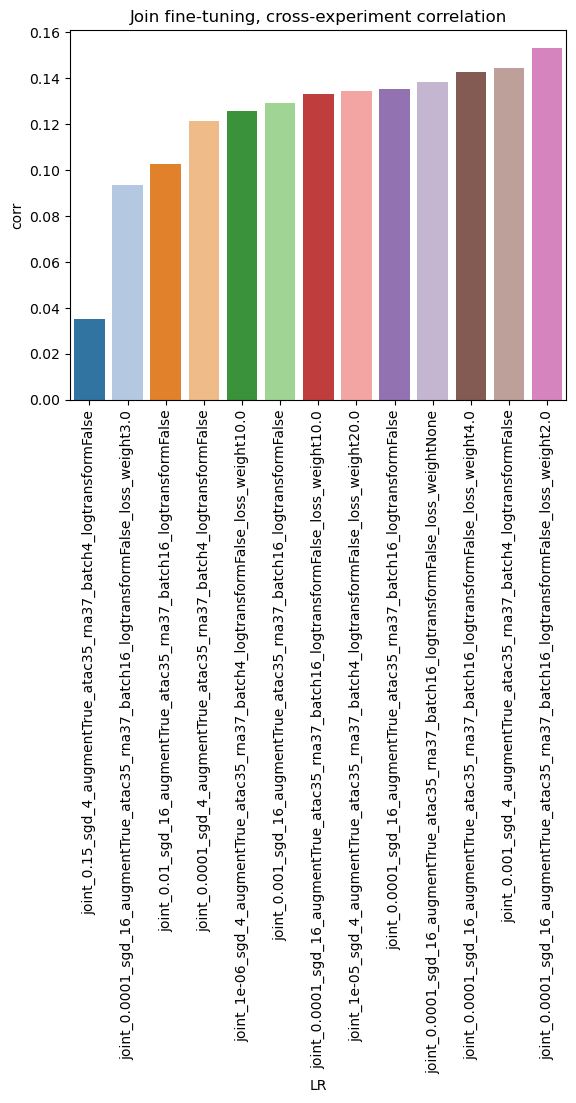

In [41]:
lr_dict_tss = {}
for key, value in corr_exp_dict_joint.items():
    lr_dict_tss[key] = value.mean()
if save:
        plot_parameter_comparison(lr_dict_tss, title="Join fine-tuning, cross-experiment correlation", 
        save_pdf=os.path.join(data_dir, "plots/finetune_rna/joint_trianing_rna_cross_exp_lr_comparison.pdf"), color_palette="Dark2")
else:
    plot_parameter_comparison(lr_dict_tss, title="Join fine-tuning, cross-experiment correlation", save_pdf=None, color_palette="Dark2")


### Cross-gene correlation at TSS

In [37]:
# Add correlation values for each expeirment across genes to the target df
lr_gene = {}
for key, value in corr_gene_dict.items():
    rna_tar[key] = value
    lr_gene[key] = value.mean()


How does the number of cell representatives for a cell type influence the correlation at the TSS across genes?

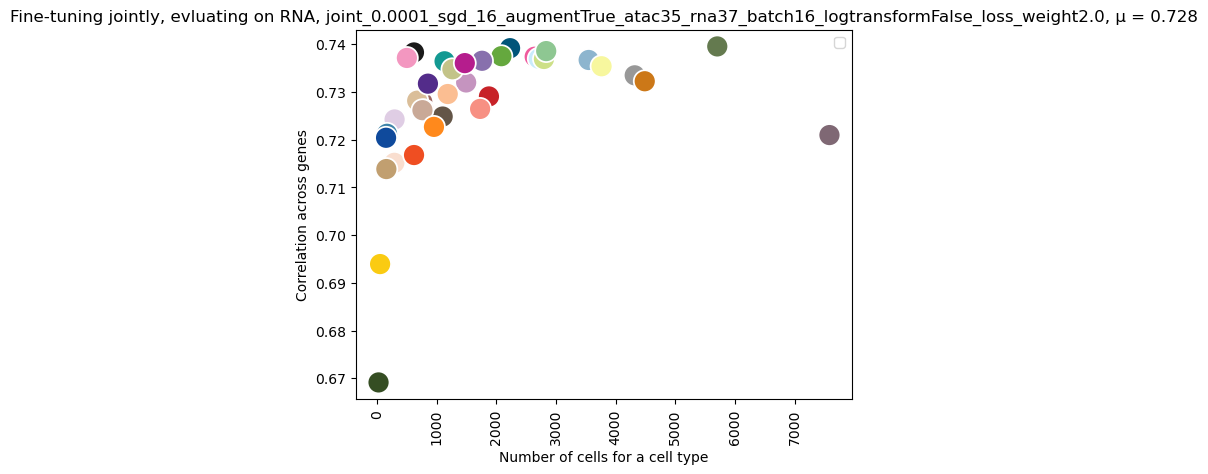

In [38]:
save=False
if save:
    corr_vs_n_cells(rna_tar, model="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight2.0", 
            title="Fine-tuning jointly, evluating on RNA", ylabel="Correlation across genes", 
            save_pdf=os.path.join(data_dir, "plots/finetune_rna/",  'best_joint_finetune_rna_cross_gene_corr_n_scatter.pdf'))
else:
    corr_vs_n_cells(rna_tar, model="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight2.0", 
            title="Fine-tuning jointly, evluating on RNA", ylabel="Correlation across genes", save_pdf=None)


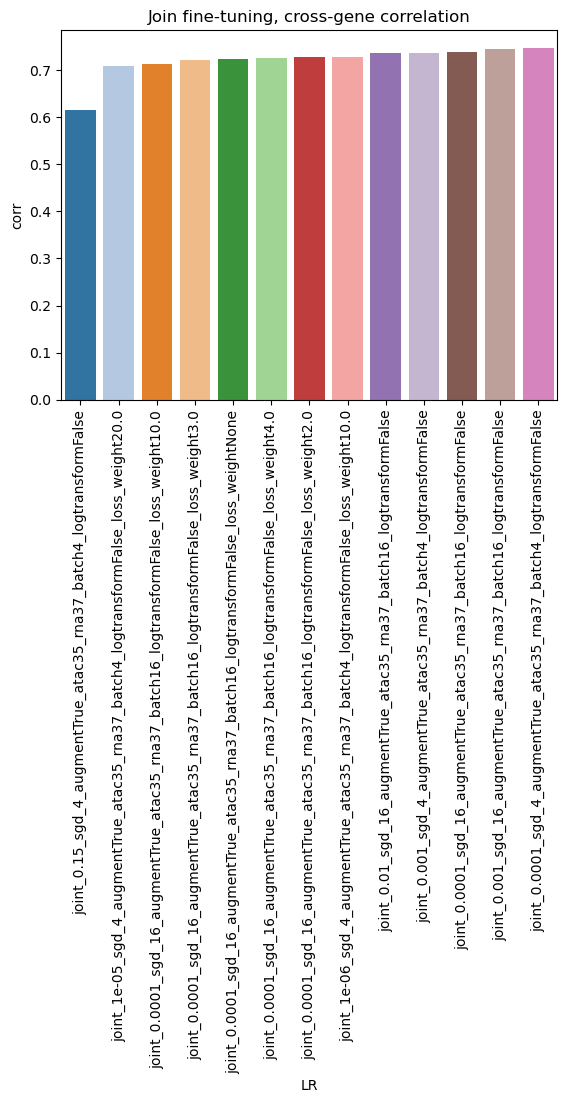

In [40]:
if save:
        plot_parameter_comparison(lr_gene, title="Join fine-tuning, cross-gene correlation", 
        save_pdf=os.path.join(data_dir, "plots/finetune_rna/joint_trianing_rna_cross_exp_lr_comparison.pdf"), color_palette="Dark2")
else:
    plot_parameter_comparison(lr_gene, title="Join fine-tuning, cross-gene correlation", save_pdf=None, color_palette="Dark2")


### Cross-experiment correlation for highly variable genes

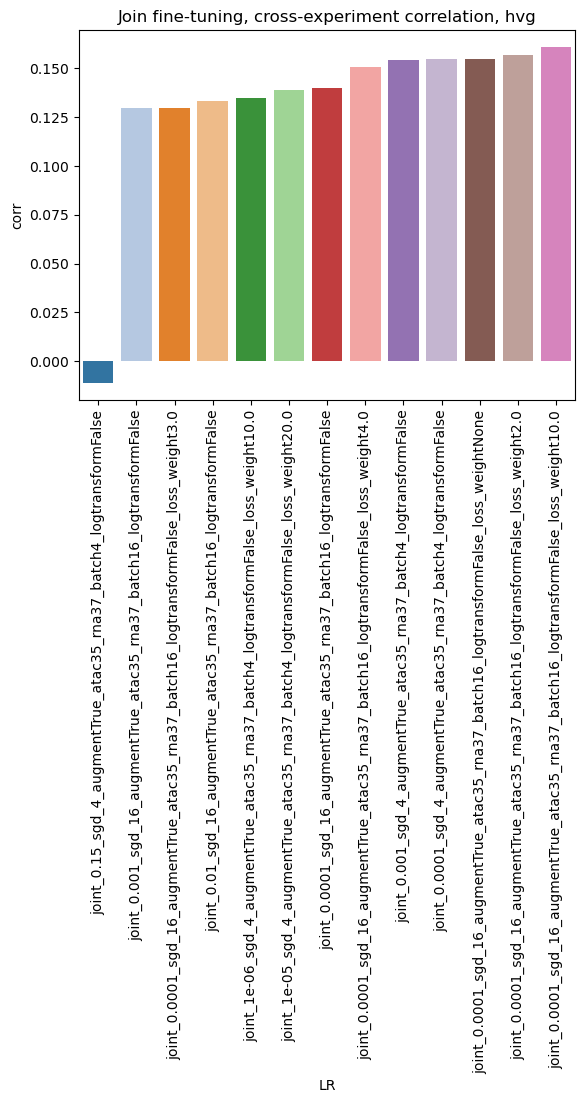

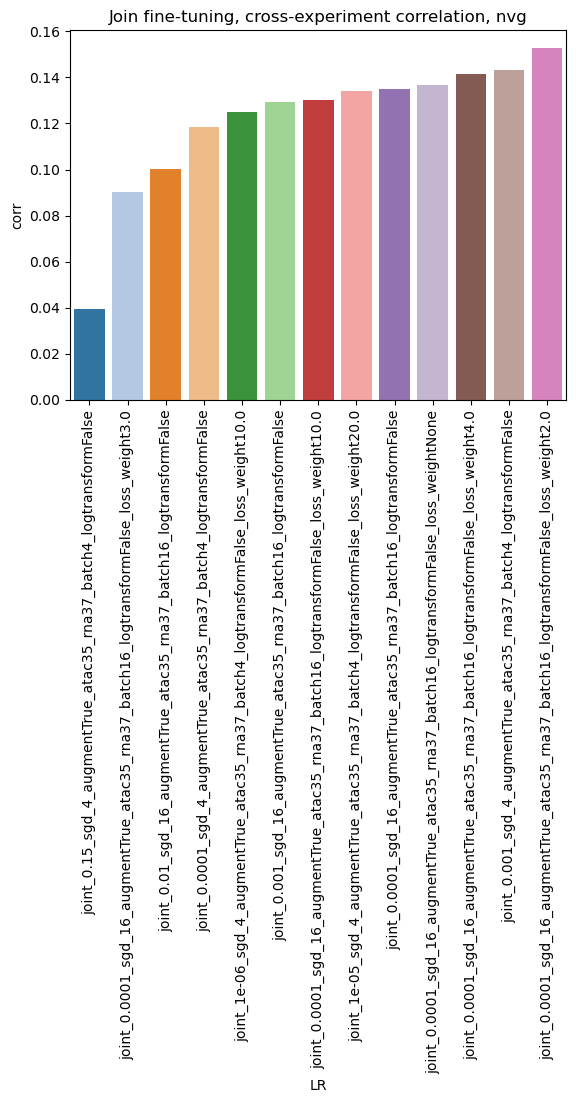

In [45]:
lr_hvg, lr_nvg = {}, {}
for name in corr_exp_hvg.keys():
    for key, value in corr_exp_hvg_joint[name].items():
        if key == "hvg":
            lr_hvg[name] = value.mean()
        if key == "nvg":
            lr_nvg[name] = value.mean()

plot_parameter_comparison(lr_hvg, title="Join fine-tuning, cross-experiment correlation, hvg", save_pdf=os.path.join(data_dir,"plots/finetune_rna/joint_trianing_rna_cross_exp_hvg_lr_comparison.pdf"), color_palette="Dark2")
plot_parameter_comparison(lr_nvg, title="Join fine-tuning, cross-experiment correlation, nvg", save_pdf=os.path.join(data_dir,"plots/finetune_rna/joint_trianing_rna_cross_exp_nvg_lr_comparison.pdf"), color_palette="Dark2")



In [62]:
import pickle
save = False
if save:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_tar_joint_finetune_cage.pkl"), "wb") as f:
        pickle.dump(rna_tar, f)
else:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_tar_joint_finetune_cage.pkl"), "rb") as f:
        rna_tar_joint = pickle.load(f)

### Finetuning only on RNA

In [49]:
rna_tar =pd.read_csv(os.path.join(data_dir, "rna_targets_gastrulation_df.txt"),sep=",", index_col=0, header=0)


In [47]:
import sys
sys.path.append('/data/mikulik/mnt/katformer/')
from cage_correlations_across_experiment import *
corr_gene_dict, corr_exp_dict, corr_exp_hvg = {}, {}, {}
for file in os.listdir(os.path.join(data_dir, "finetune_output", "correlation_cage")):
    if file.endswith("train_gene_dict.pkl") & file.startswith("finetune"):
        print(file)
        name = file.split("_train_gene_dict.pkl")[0]
        print(name)
        obj = CageCorr(data_dir=os.path.join(data_dir, "finetune_output/correlation_cage"),
                        train = name + "_train_gene_dict.pkl",
                        test = name + "_test_gene_dict.pkl",
                        valid = name + "_valid_gene_dict.pkl")

        pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"), cage=False)
        corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
        corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")
        print(corr_small_model_protein_coding_tss.mean())
        print(corr_small_model_protein_coding_tss_exp.mean())
        corr_gene_dict[name] = corr_small_model_protein_coding_tss
        corr_exp_dict[name] = corr_small_model_protein_coding_tss_exp

        # hvg
        test_rna = rna_sub.var[rna_sub.var["transcript_id"].isin(obj.gene_ids["test"])]
        select = test_rna[["transcript_id", "highly_variable"]].set_index("transcript_id").loc[obj.gene_ids["test"], :]
        corr_exp_hvg[name] = {"nvg":corr_small_model_protein_coding_tss_exp[~select.highly_variable], 
                                "hvg":corr_small_model_protein_coding_tss_exp[select.highly_variable]}

save = False
if save:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_hvg_corr.pkl"), "wb") as f:
        pickle.dump(corr_exp_hvg, f)
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_corr.pkl"), "wb") as f:
        pickle.dump(corr_exp_dict, f)
else:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_hvg_corr.pkl"), "rb") as f:
        corr_exp_hvg_rna = pickle.load(f)
        #sns.histplot(corr_small_model_protein_coding_tss_exp, bins=100)
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_corr.pkl"), "rb") as f:
        corr_exp_dict_rna = pickle.load(f)

finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse_train_gene_dict.pkl
finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse
Compute correlation across genes for test
Compute correlation across experiments for test
0.7228221140230354
0.1368076575824366
finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformTrue_train_gene_dict.pkl
finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformTrue
Compute correlation across genes for test
Compute correlation across experiments for test
0.7162528968875743
0.12231294121587408
finetune_0.0001_adam_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse_train_gene_dict.pkl
finetune_0.0001_adam_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse
Compute correlation across genes for test
Compute correlation across experiments for test
0.735243128814286
0.1261870375746862
finetune_0.001_adam_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse_train_gene_dict.pkl
fine

finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse 0.1368076575824366
finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformTrue 0.12231294121587408
finetune_0.0001_adam_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse 0.1261870375746862
finetune_0.001_adam_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse 0.13472442470434323
finetune_0.001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse 0.09752212963560625


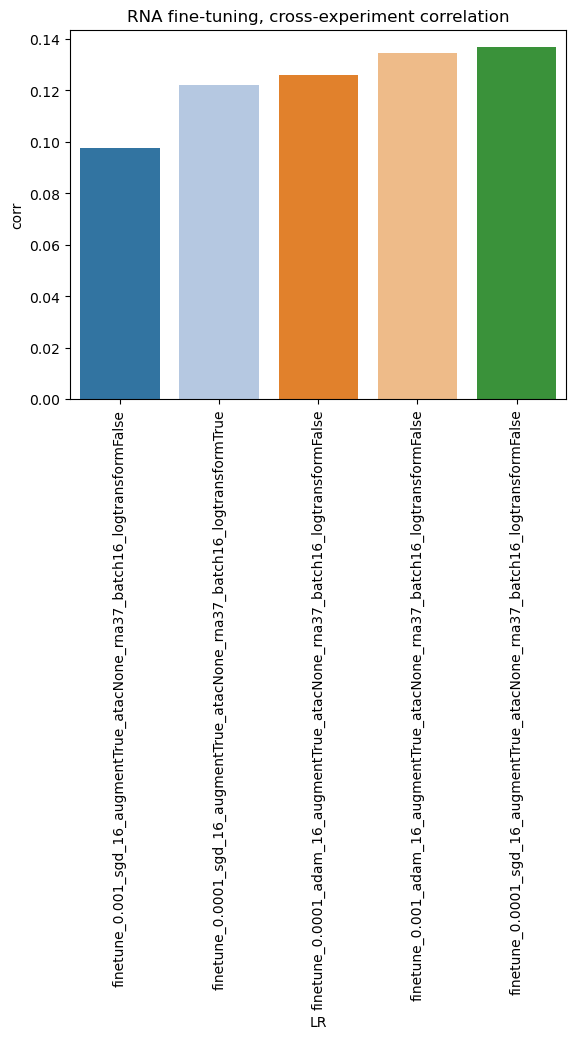

In [53]:
lr_dict_tss_rna = {}
for key, value in corr_exp_dict_rna.items():
    print(key, value.mean())
    lr_dict_tss_rna[key] = value.mean()
plot_parameter_comparison(lr_dict_tss_rna, title="RNA fine-tuning, cross-experiment correlation", save_pdf=None, color_palette="Dark2")
#save_pdf=os.path.join(data_dir, "plots/finetune_rna/rna_trianing_rna_cross_exp_lr_comparison.pdf"))

In [56]:
lr_gene_rna = {}
for key, value in corr_gene_dict.items():
    rna_tar[key] = value
    lr_gene_rna[key] = value.mean()


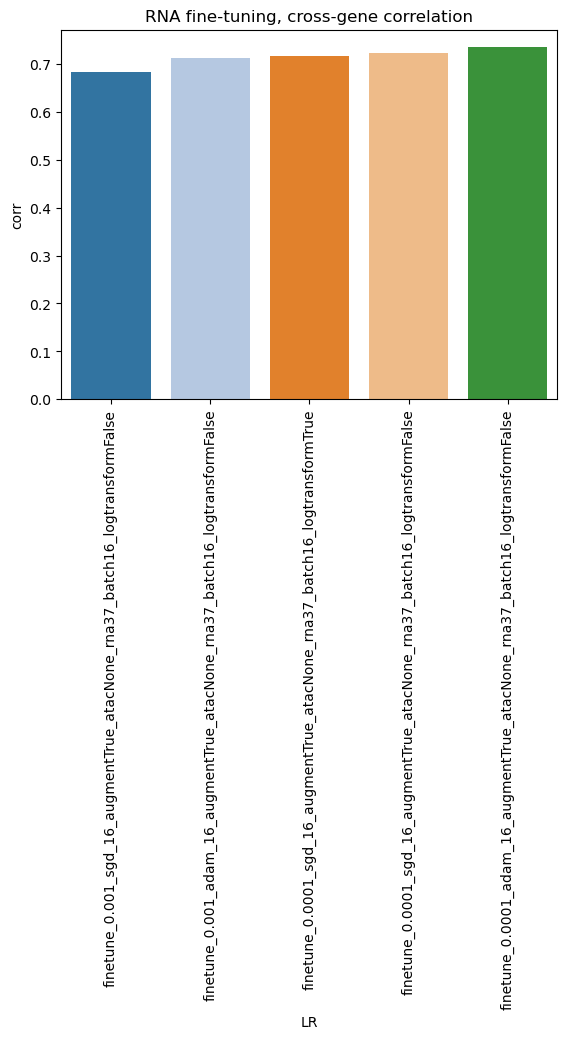

In [58]:
plot_parameter_comparison(lr_gene_rna, title="RNA fine-tuning, cross-gene correlation", save_pdf=None, color_palette="Dark2")
#save_fig=os.path.join(data_dir,"plots/finetune_rna/rna_trianing_rna_cross_gene_lr_comparison.pdf"

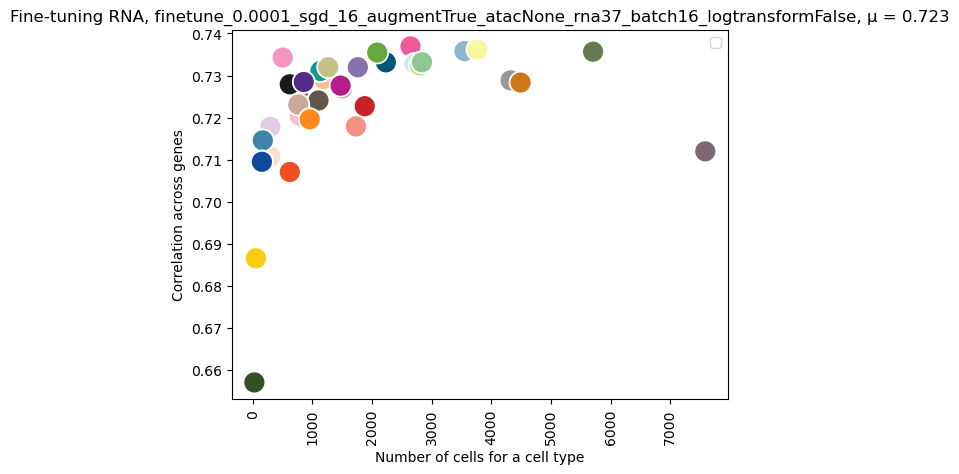

In [59]:
save=False
if save:
    corr_vs_n_cells(rna_tar, model="finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse", 
            title="Fine-tuning RNA", ylabel="Correlation across genes", 
            save_pdf=os.path.join(data_dir, "plots/finetune_rna/",  'best_rna_finetune_rna_cross_gene_corr_n_scatter.pdf'))
else:
    corr_vs_n_cells(rna_tar, model="finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse", 
            title="Fine-tuning RNA", ylabel="Correlation across genes", save_pdf=None)


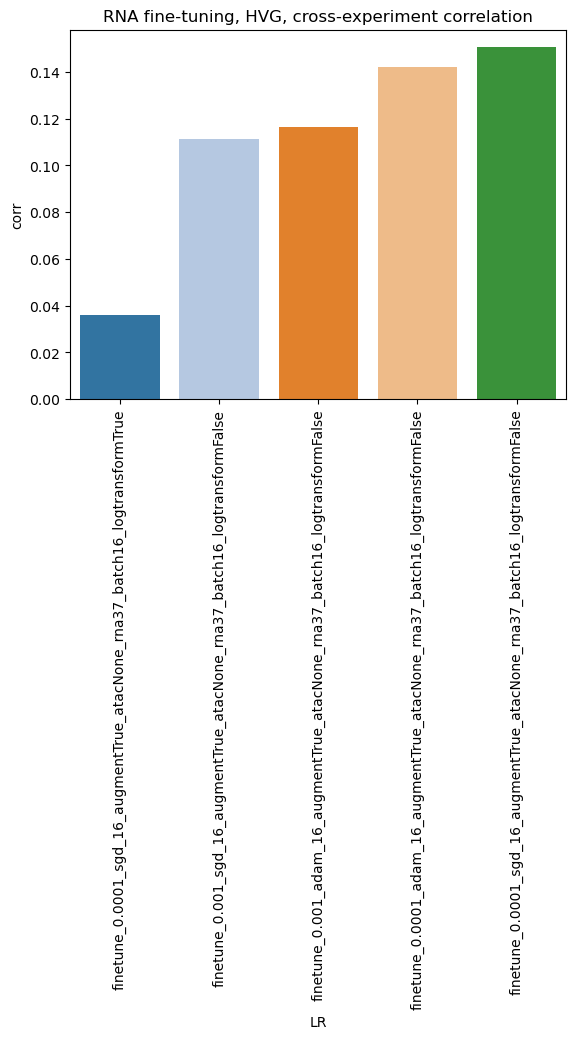

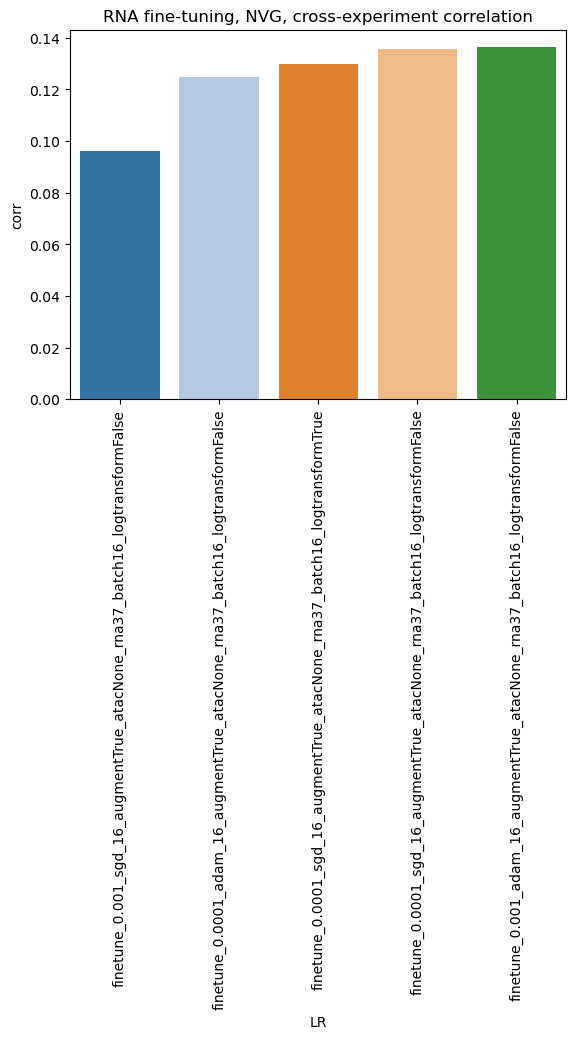

In [61]:
lr_hvg_rna, lr_nvg_rna = {}, {}
for name in corr_exp_hvg_rna.keys():
    for key, value in corr_exp_hvg_rna[name].items():
        if key == "hvg":
            lr_hvg_rna[name] = value.mean()
        if key == "nvg":
            lr_nvg_rna[name] = value.mean()

plot_parameter_comparison(lr_hvg_rna, title="RNA fine-tuning, HVG, cross-experiment correlation",
    save_pdf=os.path.join(data_dir,"plots/finetune_rna/rna_trianing_rna_cross_exp_hvg_lr_comparison.pdf"), color_palette="Dark2")

plot_parameter_comparison(lr_nvg_rna, title="RNA fine-tuning, NVG, cross-experiment correlation",
    save_pdf=os.path.join(data_dir,"plots/finetune_rna/rna_trianing_rna_cross_exp_nvg_lr_comparison.pdf"), color_palette="Dark2")

#get_lr_plot(lr_hvg_rna, sort=True, title="cross_exp_hvg", save_fig=os.path.join(data_dir,"plots/finetune_rna/rna_trianing_rna_cross_exp_hvg_lr_comparison.pdf"))
#get_lr_plot(lr_nvg_rna, sort=True, title="cross_exp_nvg", save_fig=os.path.join(data_dir,"plots/finetune_rna/rna_trianing_rna_cross_exp_nvg_lr_comparison.pdf"))

### Comparing joint fine-tuning vs RNA fine-tuning


#### Correlation across genes

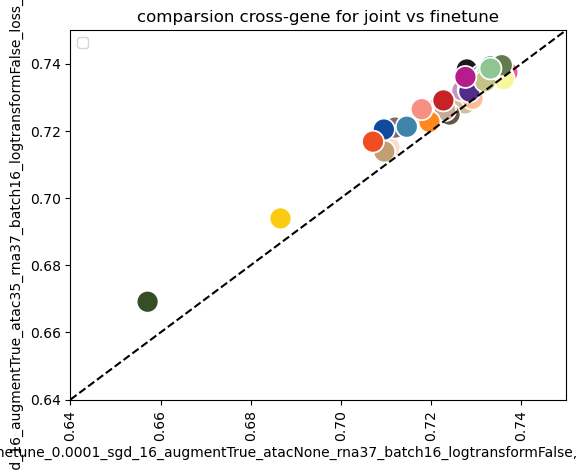

In [63]:
with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_tar_joint_finetune_cage.pkl"), "rb") as f:
    rna_tar_joint = pickle.load(f)

# select best performing model for joint and separate fine-tunign (as measured by correaltion at gene TSS)
key = "finetune_0.0001_sgd_16_augmentTrue_atacNone_rna37_batch16_logtransformFalse"
key_join = "joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight2.0"

# color palette
unique_colors = rna_tar['color'].unique()
custom_palette = sns.color_palette(unique_colors)
sns.set_palette = custom_palette

# add the correlation values from joint fine-tuning to the target df of single fine-tuning
rna_tar[key_join] = rna_tar_joint[key_join]
sns.scatterplot(rna_tar,x=rna_tar[key], y=rna_tar[key_join],
                hue="celltype", s=250, palette=custom_palette)
sns.lineplot(x=[0.64,0.75], y=[0.64,0.75], color="black", linestyle='--')

plt.xlabel(f"{key}, µ = {rna_tar[key].mean():.3f}")
plt.title("comparsion cross-gene for joint vs finetune")
plt.ylabel(f"{key_join}, µ = {rna_tar_joint[key_join].mean():.3f}")
plt.xticks(rotation=90)
plt.legend([])
plt.ylim([0.64,0.75])
plt.xlim([0.64,0.75])
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/",  'best_rna_joint_comparison_finetune_rna_cross_gene_corr_n_scatter.pdf'), format='pdf')
plt.show()

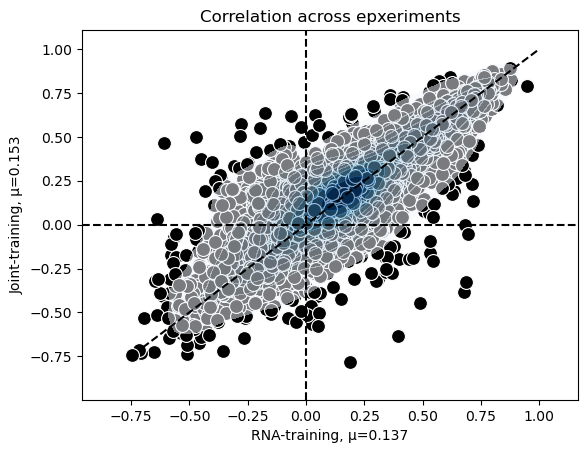

In [65]:
# get the cross-experiment correlation values fro joint and rna fine-tuning
a,b = corr_exp_dict_rna[key], corr_exp_dict_joint[key_join]

# plot
sns.scatterplot(x=a, y=b, color="black", s=100)
sns.kdeplot(x=a, y=b, fill=True, alpha=0.5, cmap="Blues")
plt.axhline(y=0, color="black", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
sns.lineplot(x=[-0.70, 1], y=[-0.70, 1], color="black", linestyle='--')
plt.title("Correlation across epxeriments")
plt.xlabel(f"RNA-training, µ={a.mean():.3f}")
plt.ylabel(f"Joint-training, µ={b.mean():.3f}")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "comp_joint_rna.pdf"), format="pdf")
plt.show()

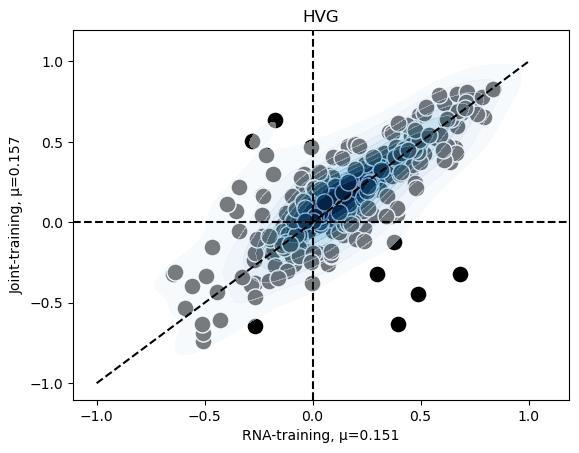

In [66]:
hvg_rna, nvg_rna = corr_exp_hvg_rna[key]["hvg"], corr_exp_hvg_rna[key]["nvg"]
hvg_joint, nvg_joint = corr_exp_hvg_joint[key_join]["hvg"], corr_exp_hvg_joint[key_join]["nvg"]
sns.scatterplot(x=hvg_rna, y=hvg_joint,s=150, color="black")
sns.kdeplot(x=hvg_rna, y=hvg_joint, fill=True, alpha=0.5, cmap="Blues")
plt.axhline(y=0, color="black", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
sns.lineplot(x=[-1,1], y=[-1,1], color="black", linestyle='--')
#plt.ylim([-1,1])
#plt.xlim([-1,1])
plt.title("HVG")
plt.xlabel(f"RNA-training, µ={hvg_rna.mean():.3f}")
plt.ylabel(f"Joint-training, µ={hvg_joint.mean():.3f}")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "comp_hvg_joint_rna.pdf"), format="pdf")
plt.show()

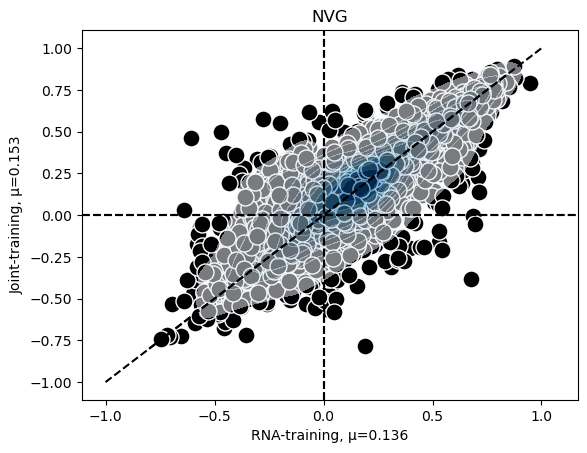

In [67]:
sns.scatterplot(x=nvg_rna, y=nvg_joint,s=150, color="black")
sns.lineplot(x=[-0.8, 0.85], y=[-0.8, 0.85], color="black", linestyle='--')
plt.axhline(y=0, color="black", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
sns.kdeplot(x=nvg_rna, y=nvg_joint, fill=True, alpha=0.5, cmap="Blues")
plt.axhline(y=0, color="black", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
sns.lineplot(x=[-1,1], y=[-1,1], color="black", linestyle='--')
#plt.ylim(-0.8, 0.85)
#plt.xlim(-0.8, 0.85)
plt.title("NVG")
plt.xlabel(f"RNA-training, µ={nvg_rna.mean():.3f}")
plt.ylabel(f"Joint-training, µ={nvg_joint.mean():.3f}")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "comp_nvg_joint_rna.pdf"), format="pdf")

plt.show()

### get hvg

In [299]:
rna_sub = sc.read_h5ad(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "rna_sub.h5ad"))
sc.pp.normalize_total(rna_sub, target_sum=1e4)
sc.pp.log1p(rna_sub)
sc.pp.highly_variable_genes(rna_sub, n_top_genes=3000, min_mean=0.0125, max_mean=3, min_disp=0.5)

#sc.pl.highly_variable_genes(rna_sub)
rna.raw = rna_sub
#rna = rna[:, rna.var.highly_variable]


/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [301]:
#import sys
#sys.path.append('/data/mikulik/mnt/katformer/')
#
#from cage_correlations_across_experiment import *
#
data_dir = "/data/mikulik/mnt/gcs_basenj/"

# small model trained for month
obj = CageCorr(data_dir=os.path.join(data_dir, "finetune_output/correlation_cage"),
                        train="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_train_gene_dict.pkl",
                        test="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_test_gene_dict.pkl",
                        valid="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_valid_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"), cage=False)
corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")

Compute correlation across genes for test
Compute correlation across experiments for test


(3102,)
0.13946884120608352
(278,)
0.1521950319988829


<Axes: ylabel='Count'>

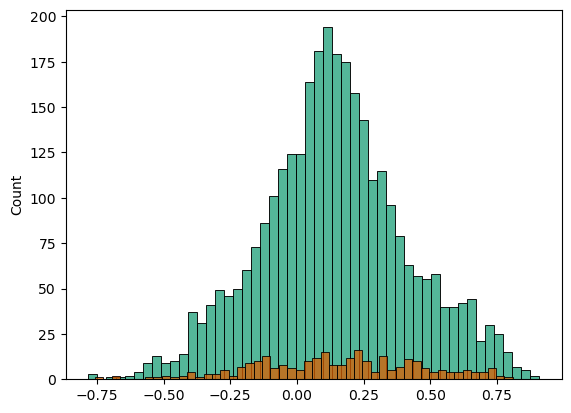

In [302]:
test_rna = rna_sub.var[rna_sub.var["transcript_id"].isin(obj.gene_ids["test"])]
select = test_rna[["transcript_id", "highly_variable"]].set_index("transcript_id").loc[obj.gene_ids["test"], :]
print(corr_small_model_protein_coding_tss_exp[~select.highly_variable].shape)
print(corr_small_model_protein_coding_tss_exp[~select.highly_variable].mean())
sns.histplot(corr_small_model_protein_coding_tss_exp[~select.highly_variable], bins=50)

print(corr_small_model_protein_coding_tss_exp[select.highly_variable].shape)
print(corr_small_model_protein_coding_tss_exp[select.highly_variable].mean())
sns.histplot(corr_small_model_protein_coding_tss_exp[select.highly_variable], bins=50)

### Evaluation

#### No z-score

In [71]:
obj = CageCorr(data_dir=os.path.join(data_dir, "finetune_output/correlation_cage"),
                        train="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_train_gene_dict.pkl",
                        test="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_test_gene_dict.pkl",
                        valid="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_valid_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"), cage=False, z_score=False)
corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")
print(corr_small_model_protein_coding_tss.mean())
print(corr_small_model_protein_coding_tss_exp[~np.isnan(corr_small_model_protein_coding_tss_exp)].mean())
#sns.histplot(corr_small_model_protein_coding_tss_exp, bins=100)

Compute correlation across genes for test
Compute correlation across experiments for test


/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0.72651883975744
0.10049461371445188


#### z-score

In [73]:
obj = CageCorr(data_dir=os.path.join(data_dir, "finetune_output/correlation_cage"),
                        train="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_train_gene_dict.pkl",
                        test="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_test_gene_dict.pkl",
                        valid="joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight4.0_valid_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"), cage=False)
corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")
print(corr_small_model_protein_coding_tss.mean())
print(corr_small_model_protein_coding_tss_exp.mean())

#sns.histplot(corr_small_model_protein_coding_tss_exp, bins=100)

Compute correlation across genes for test
Compute correlation across experiments for test
0.7265188397959317
0.14245171545461122


In [74]:
a, b = obj.get_subset("train")
a_raw, b_raw = obj.raw_pred.copy(), obj.raw_tar.copy()
a_log, b_log = np.log(obj.raw_pred.copy() + 1), np.log(obj.raw_tar.copy() + 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


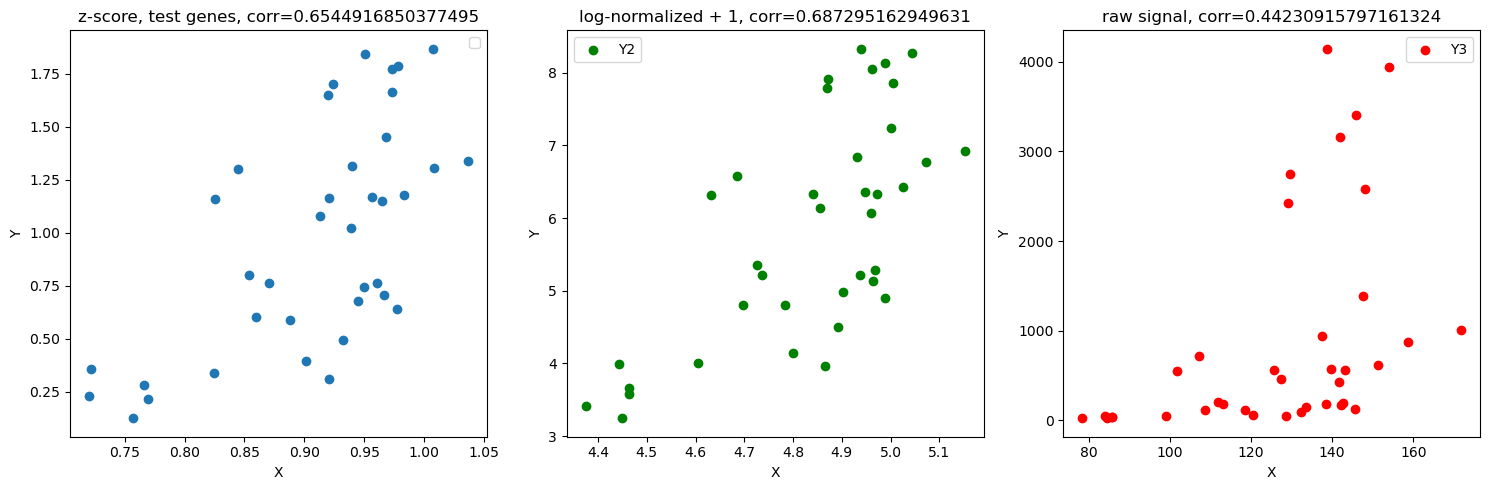

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


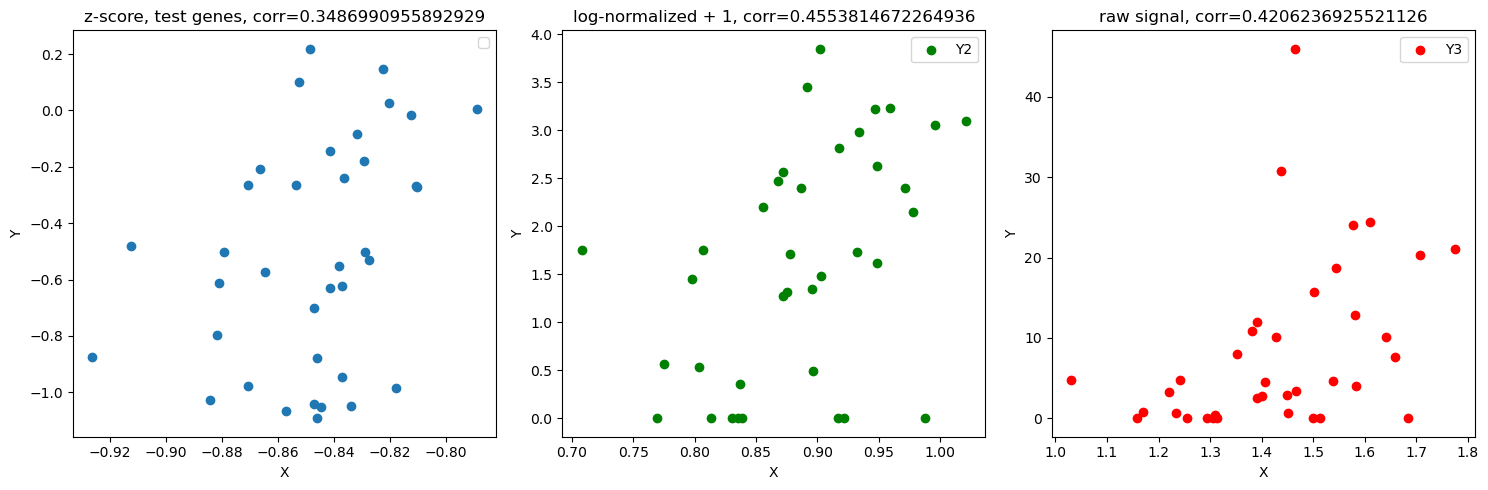

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


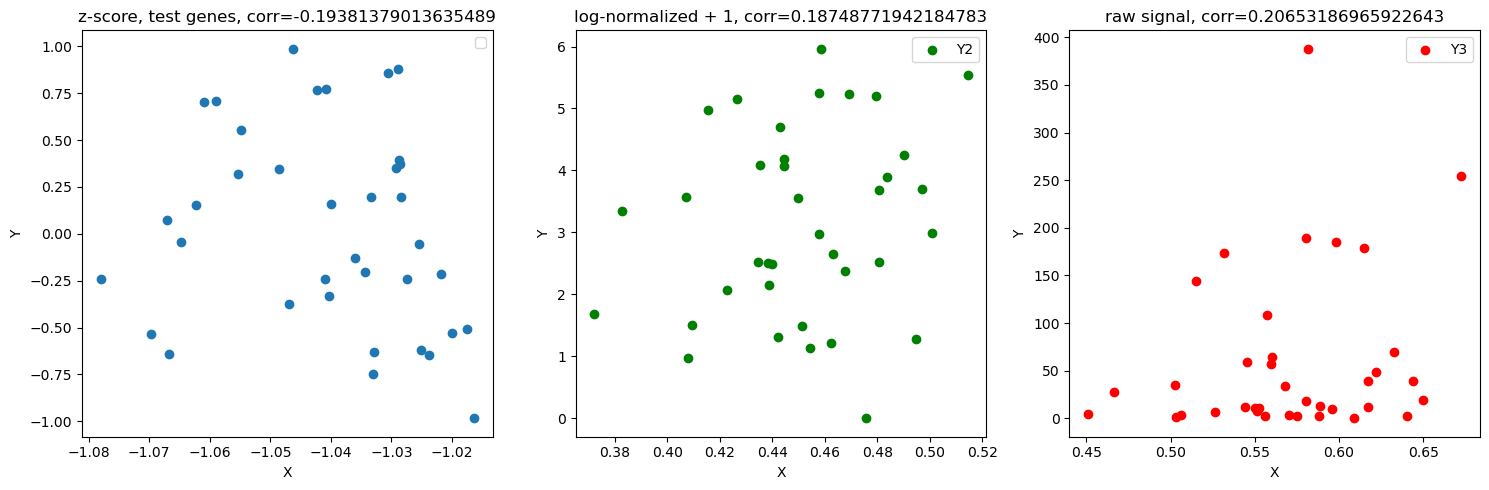

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


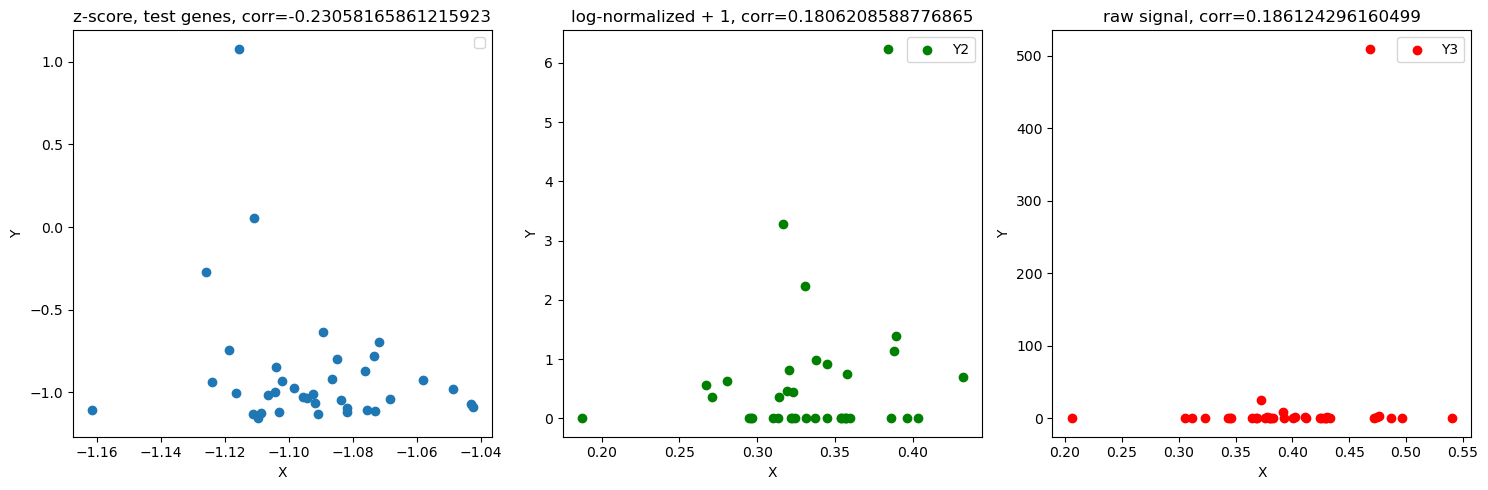

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


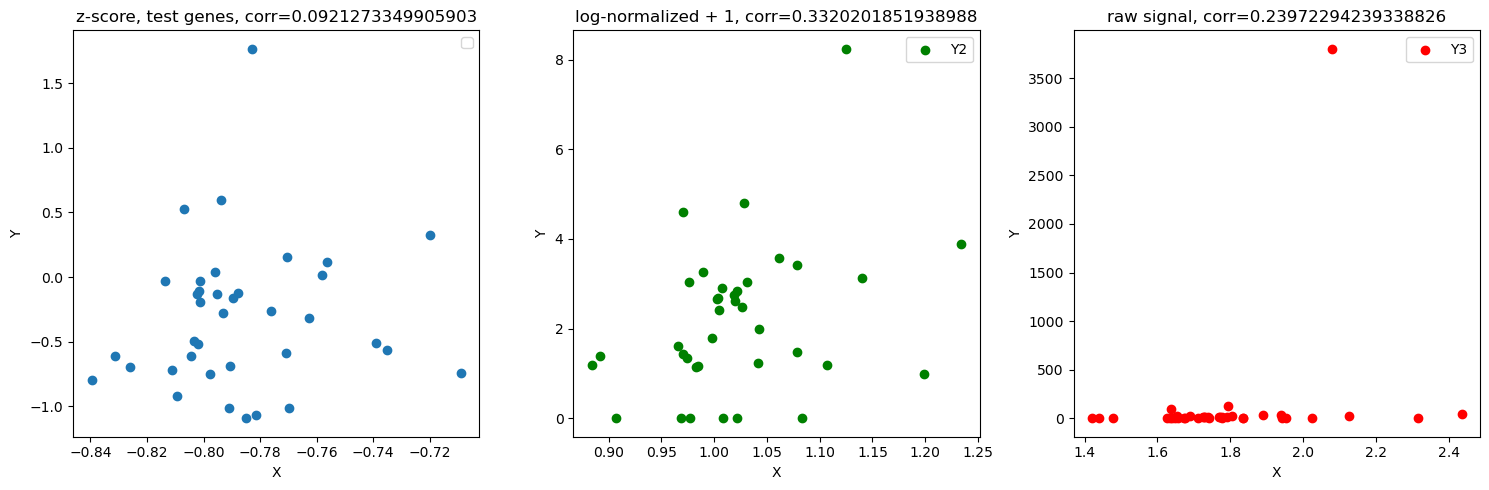

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


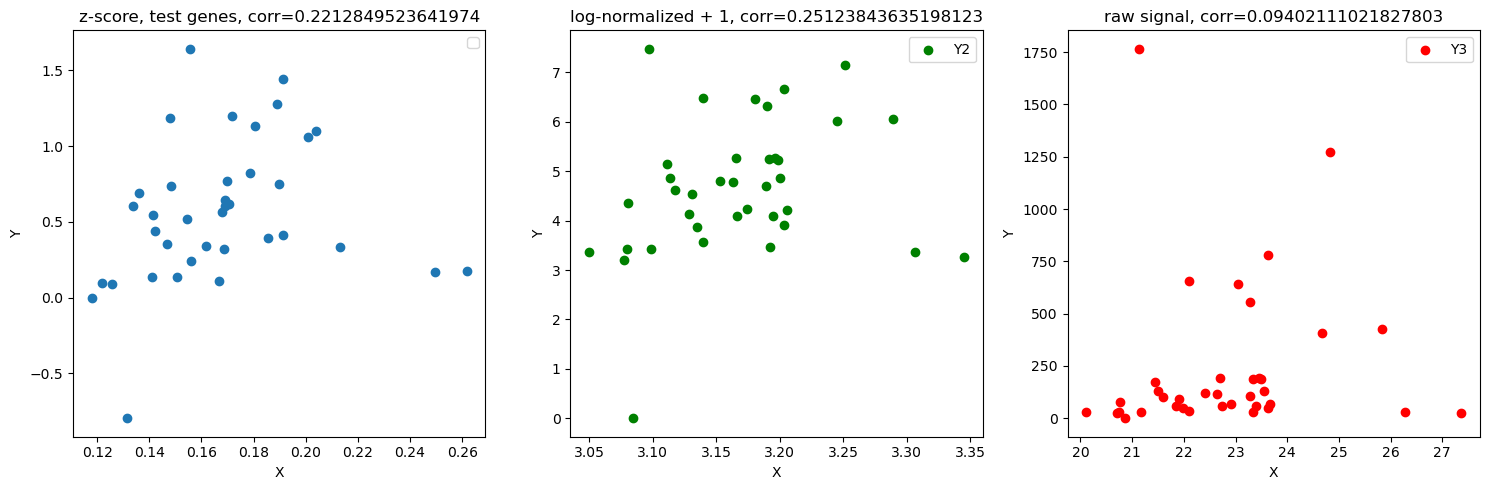

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


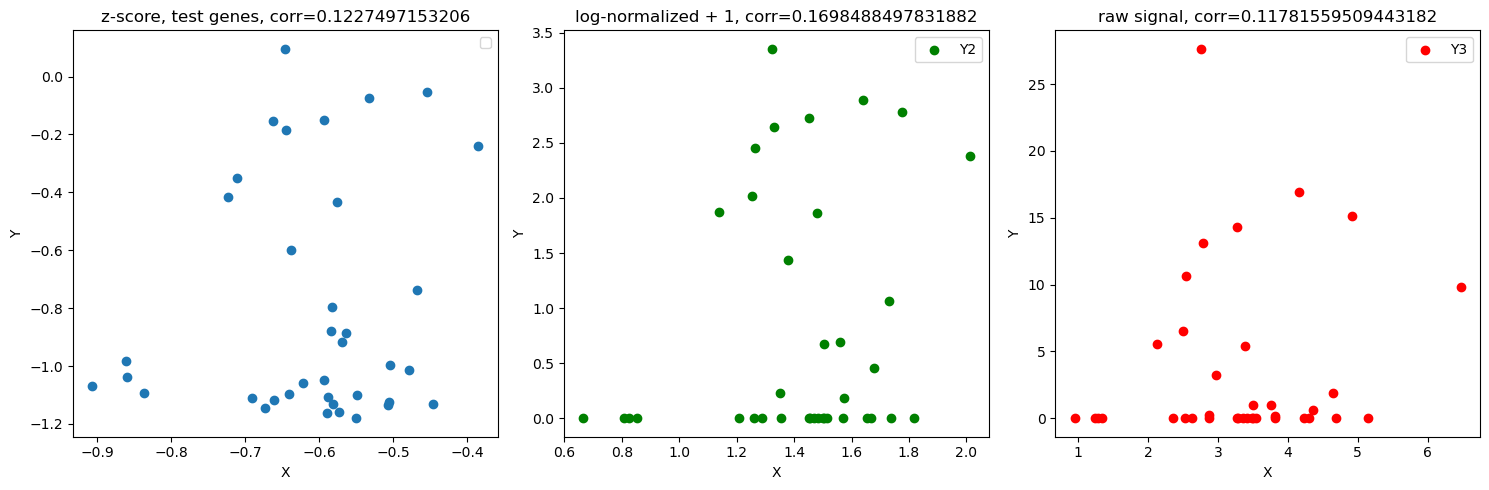

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


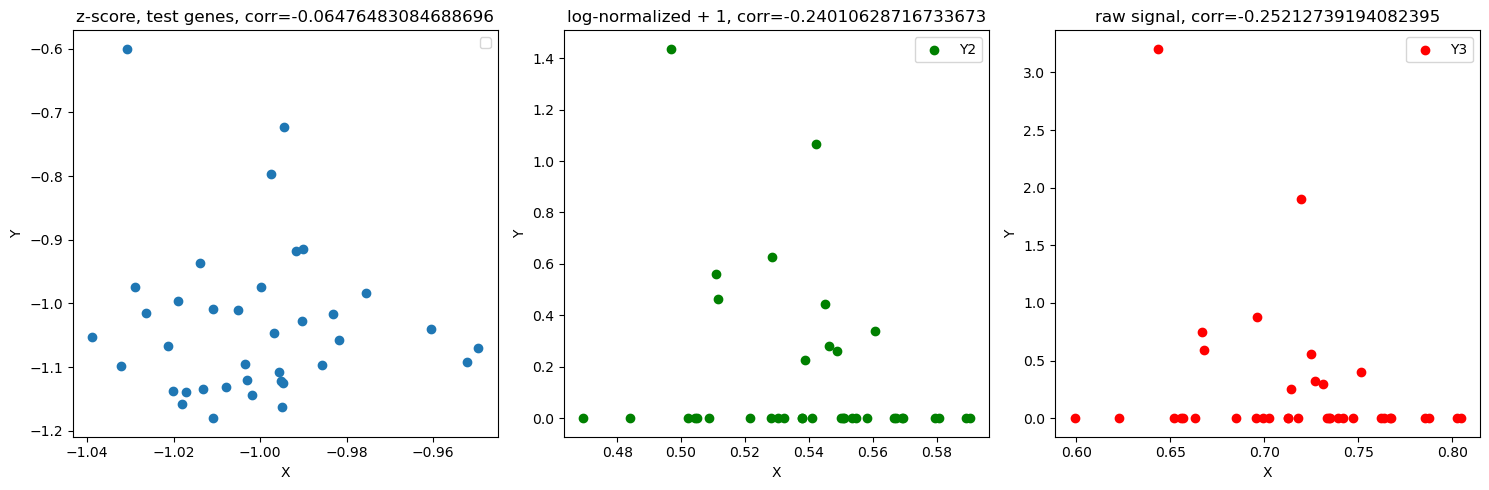

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


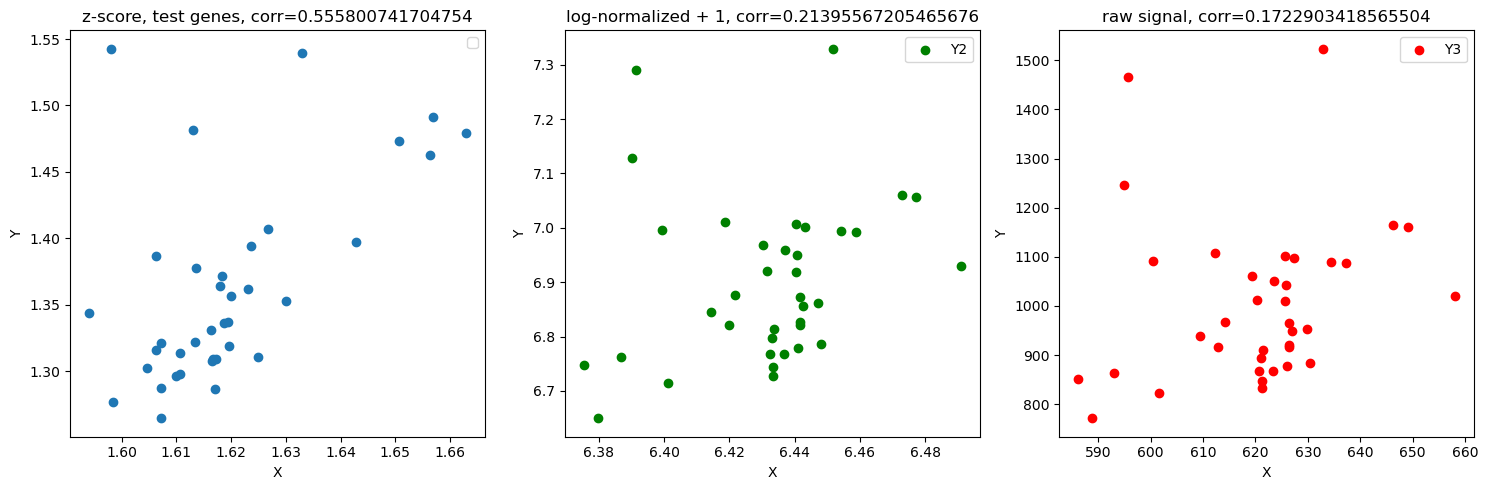

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


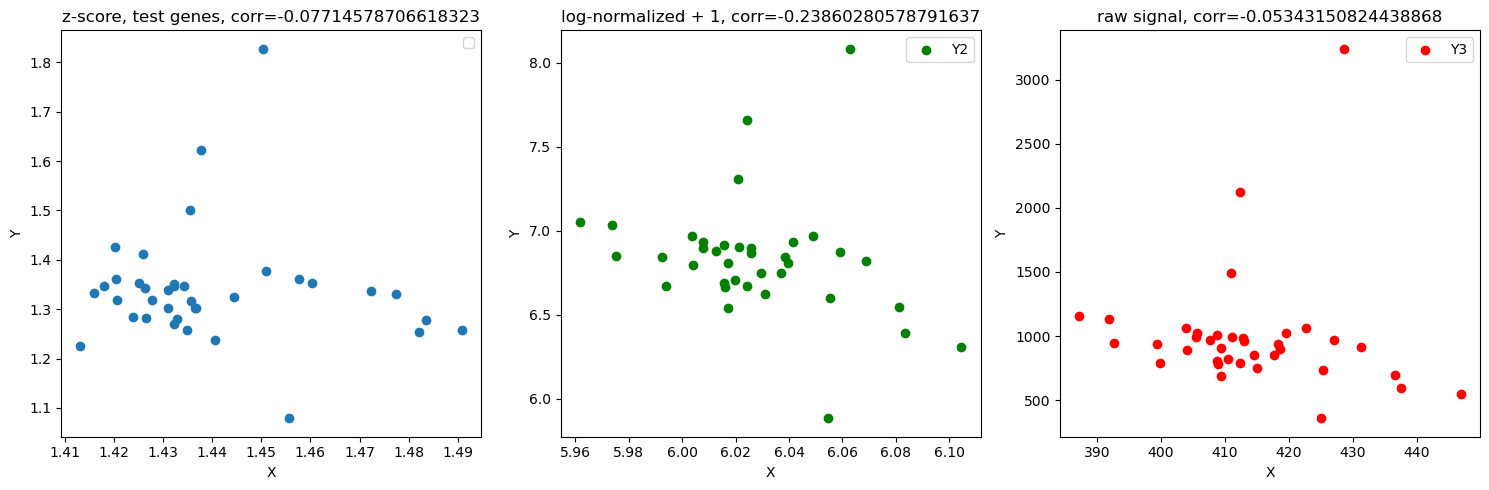

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


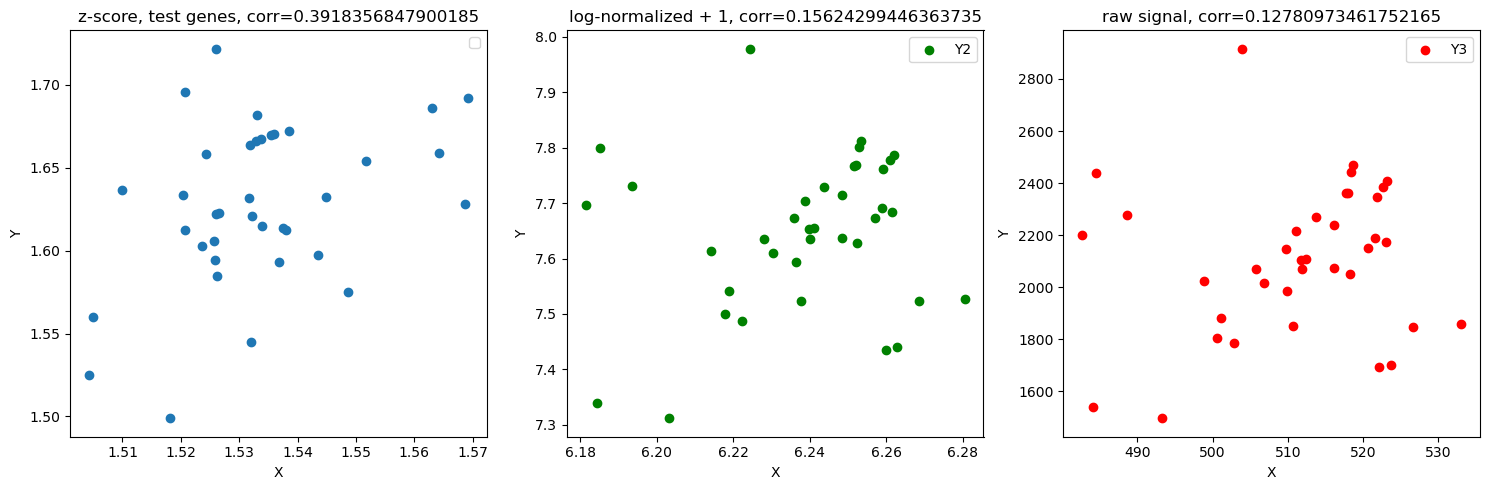

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


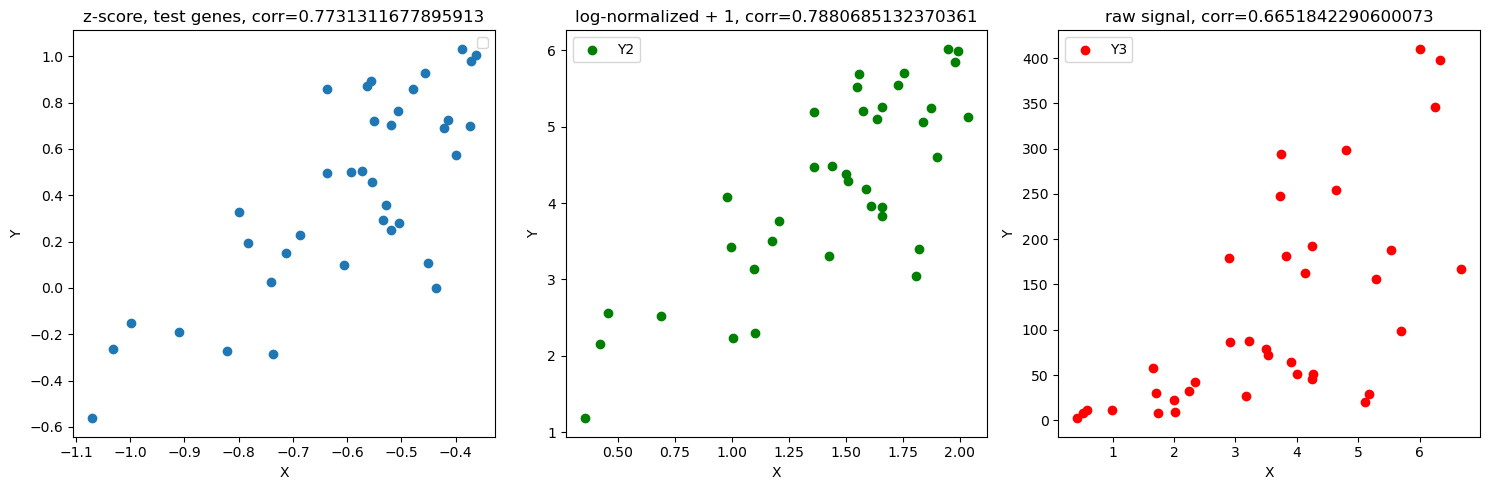

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


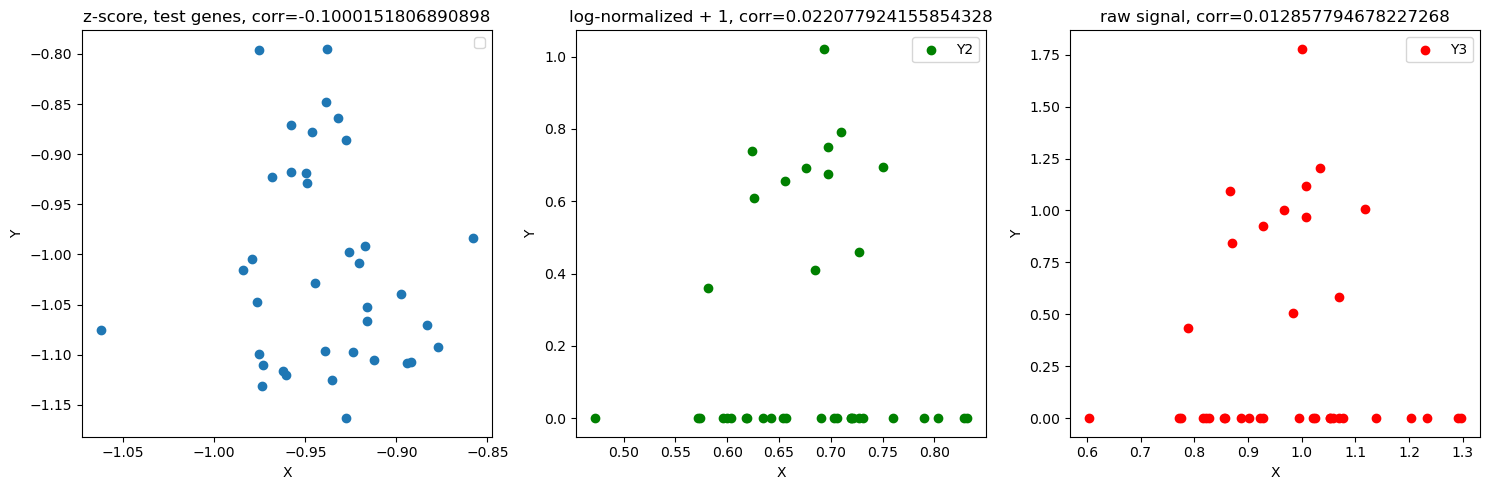

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


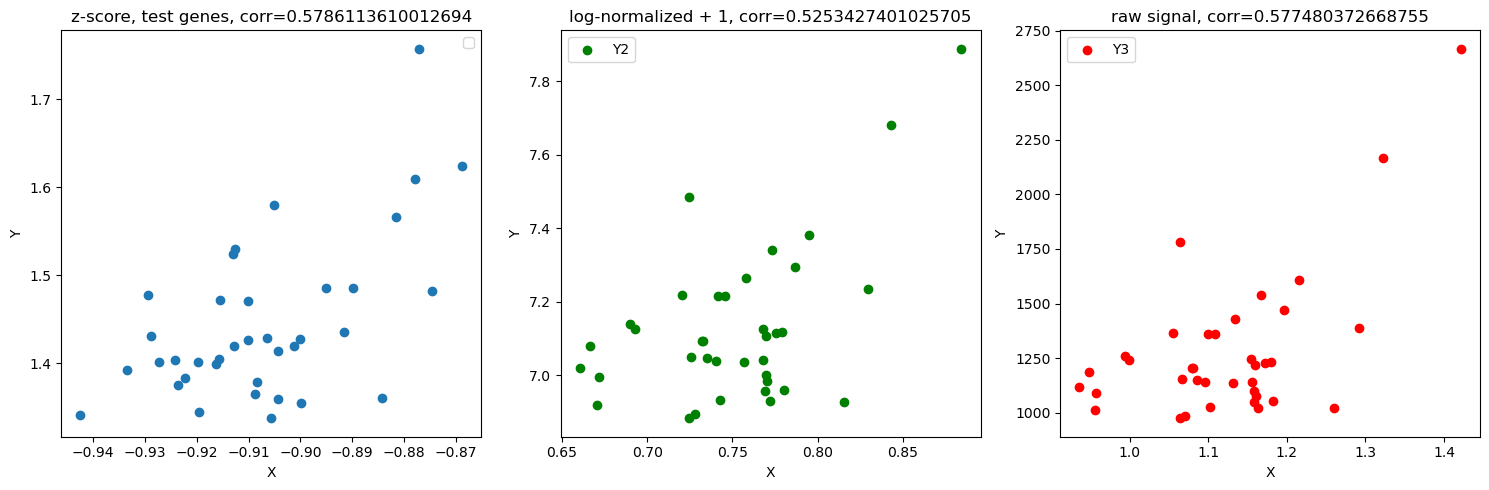

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


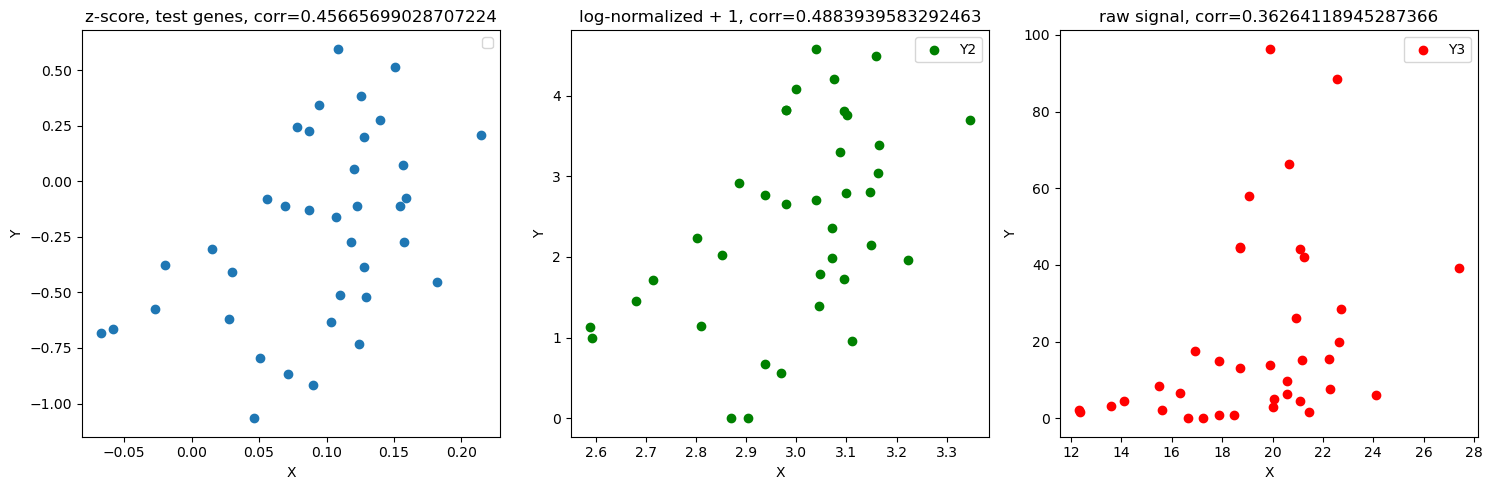

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


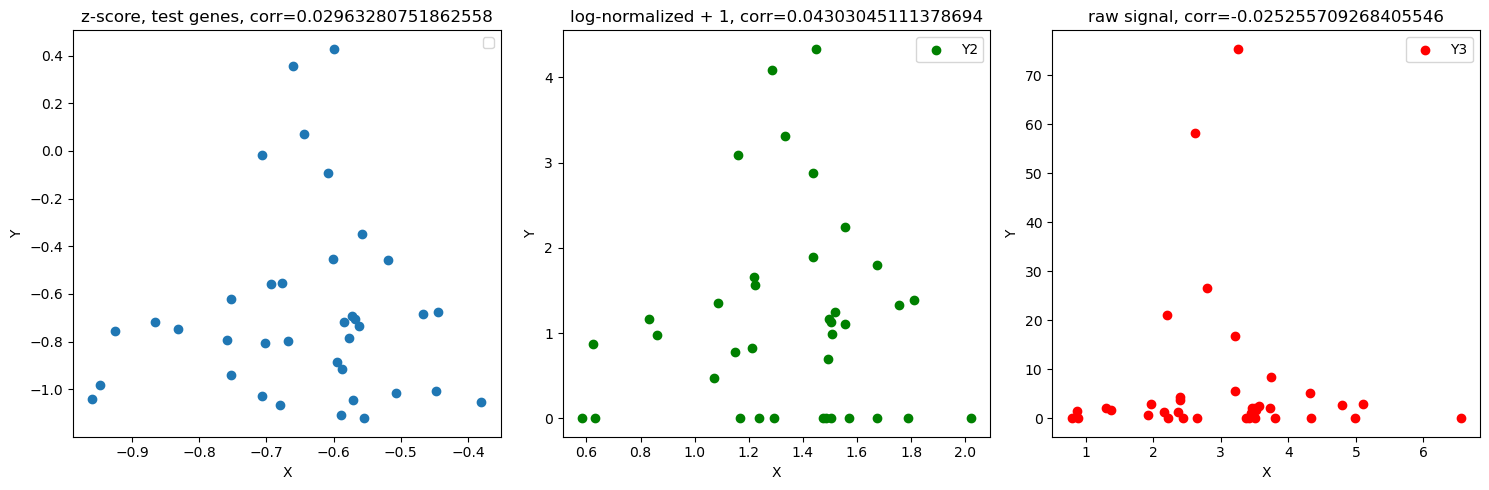

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


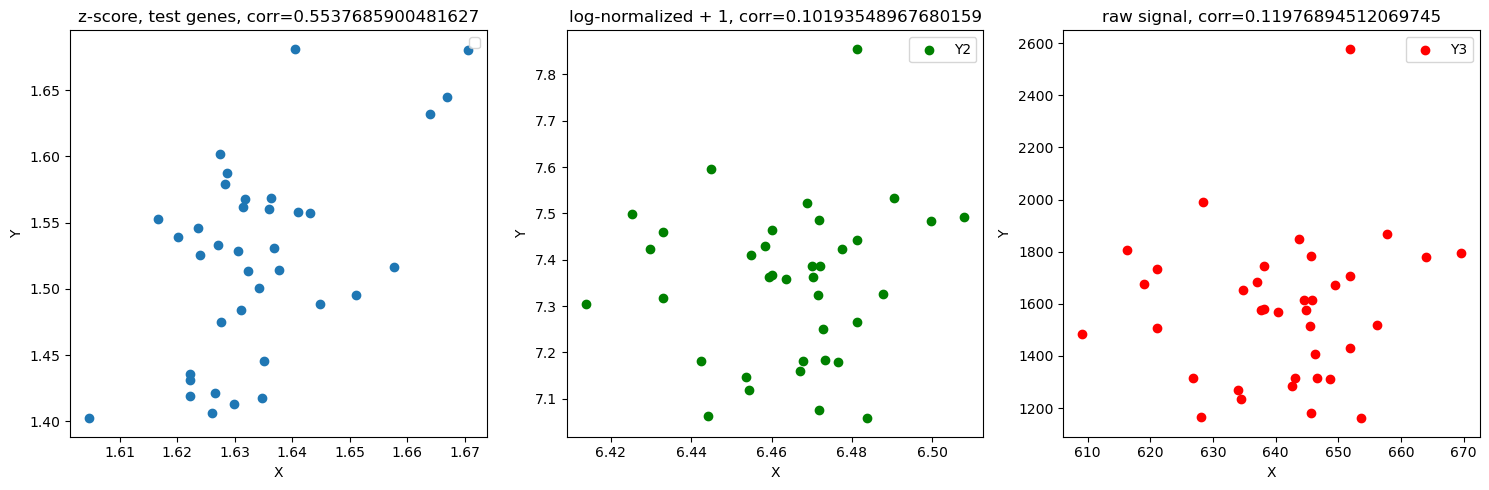

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


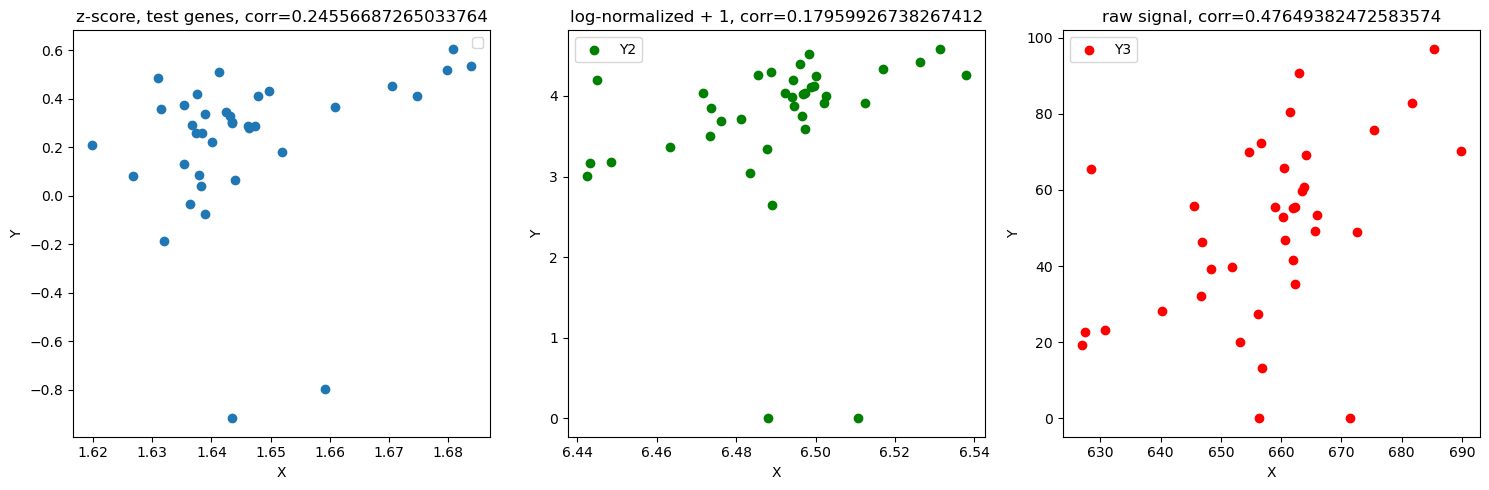

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


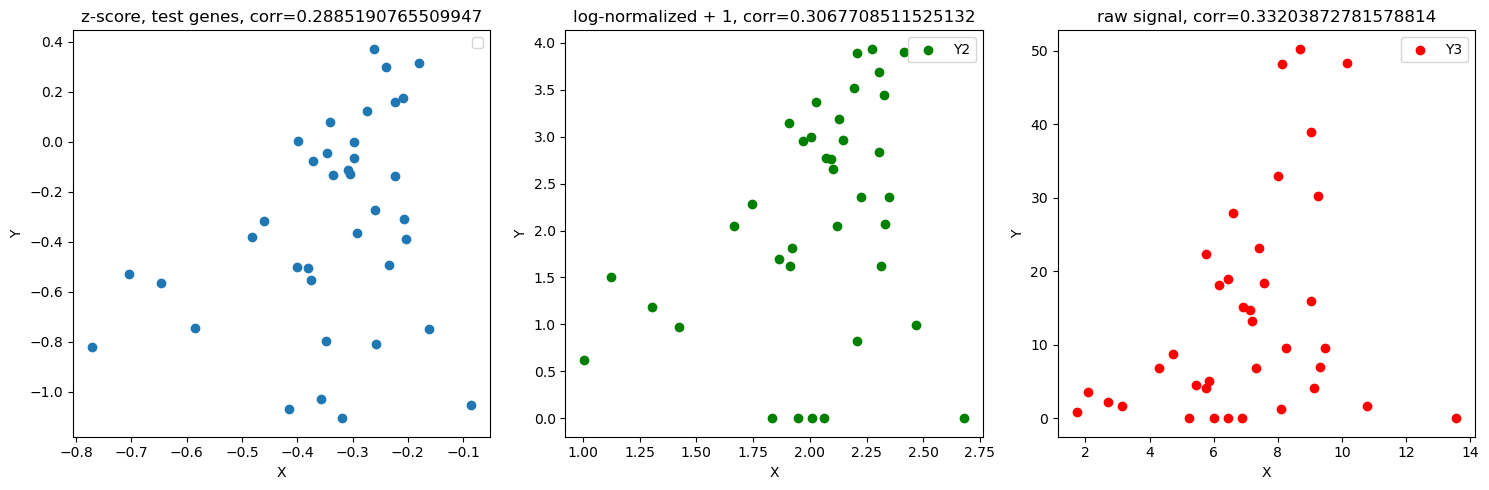

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


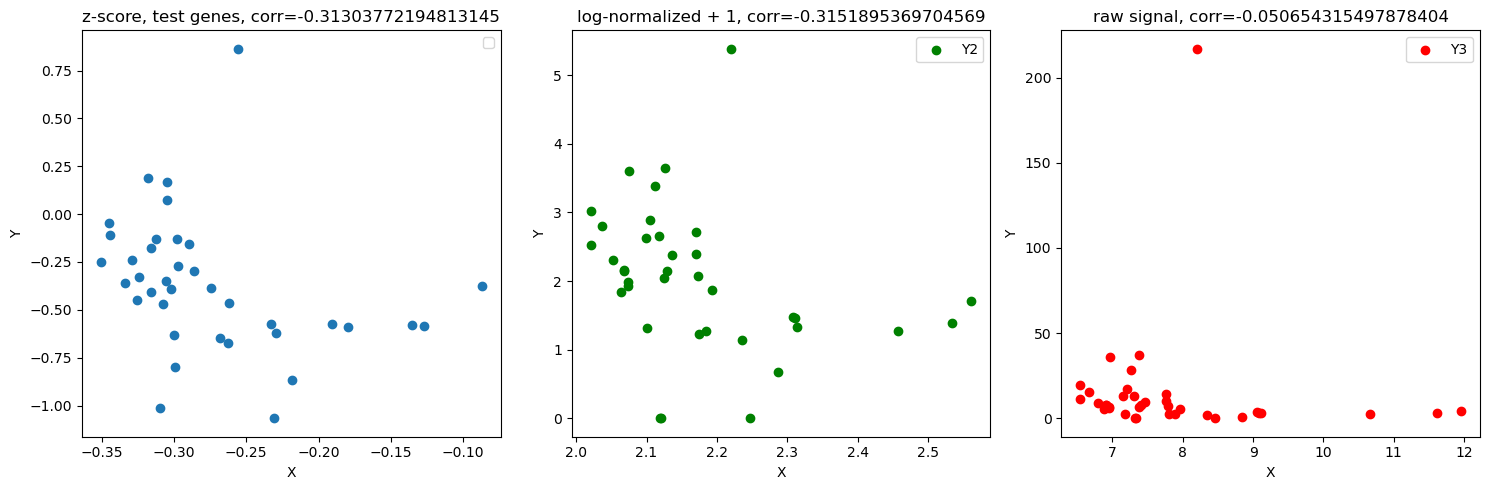

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


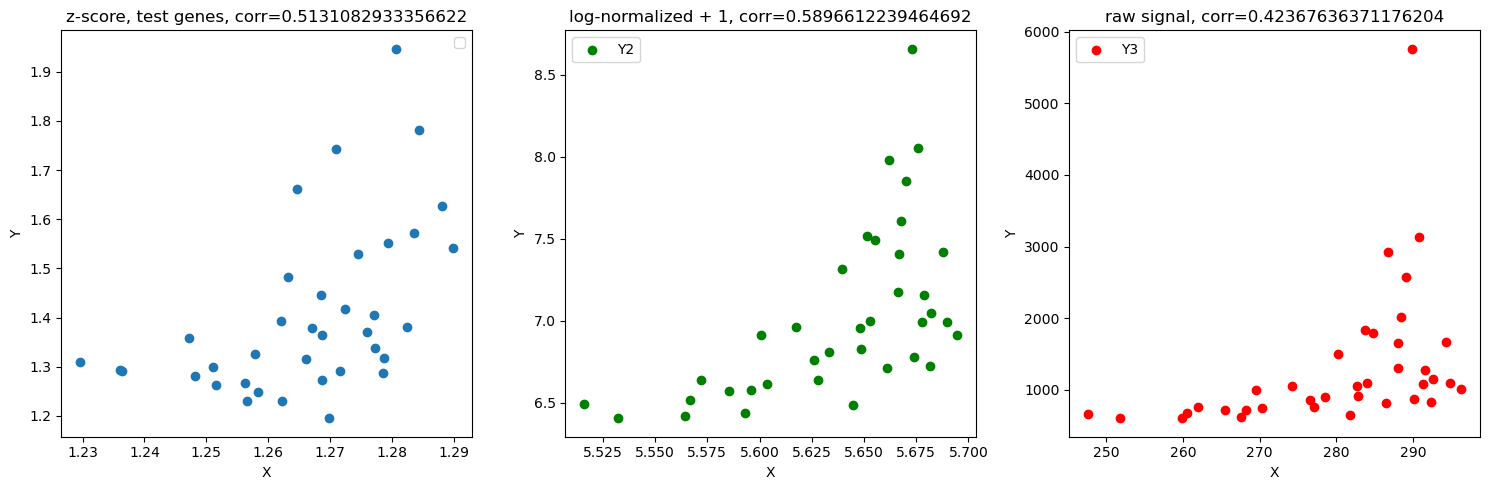

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


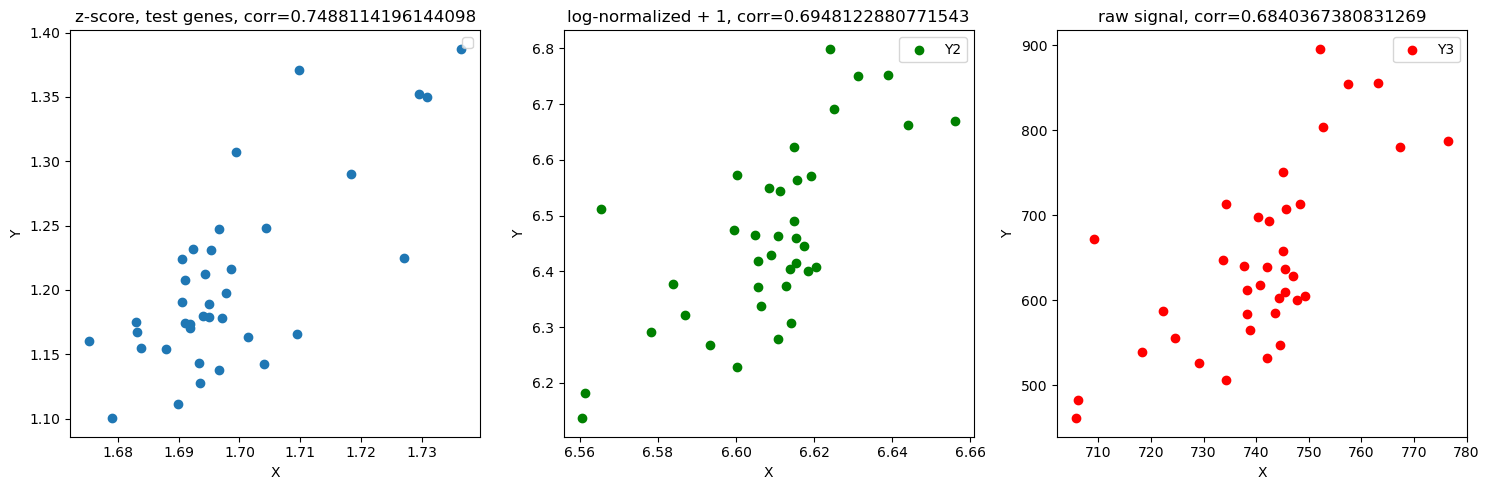

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


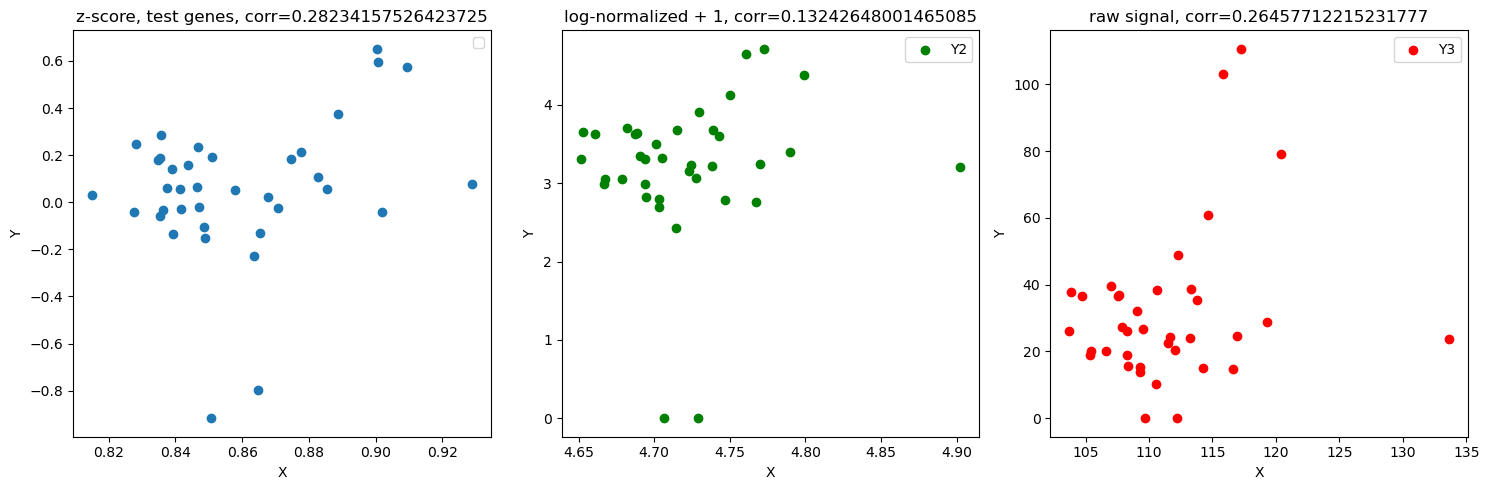

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


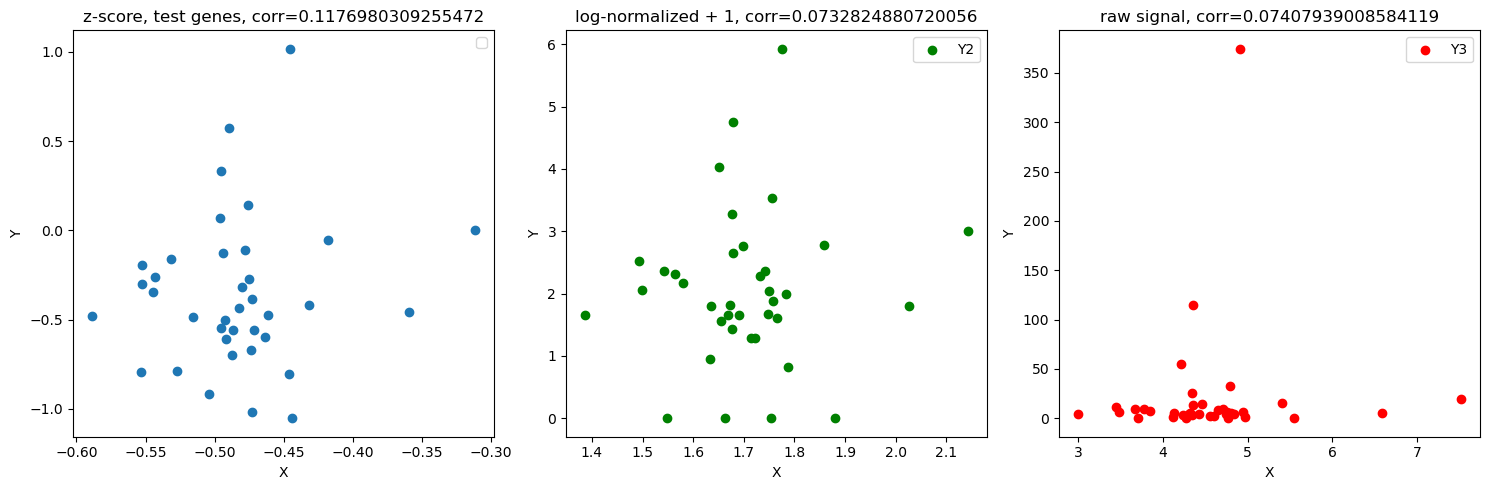

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


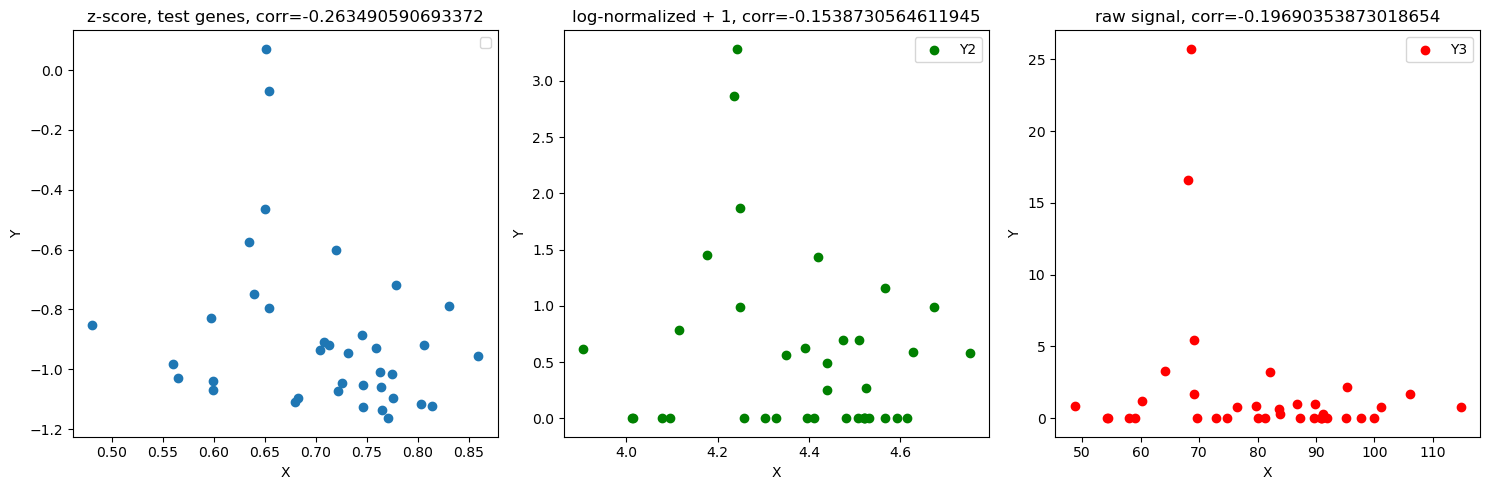

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/mikulik/miniconda3/envs/torch_gpu/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


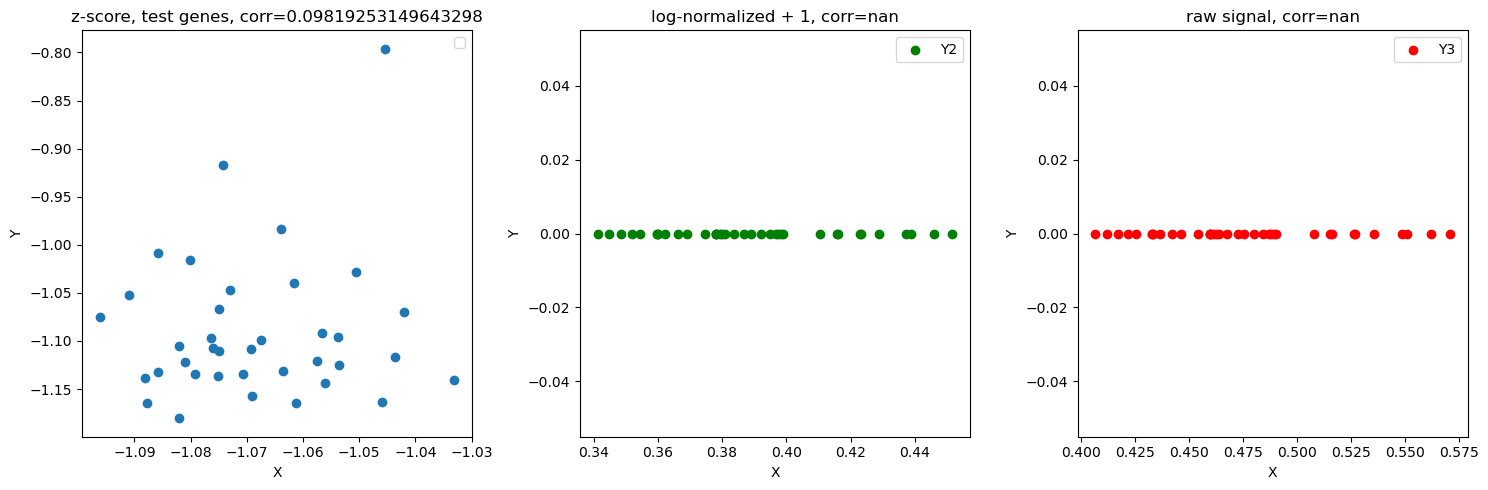

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


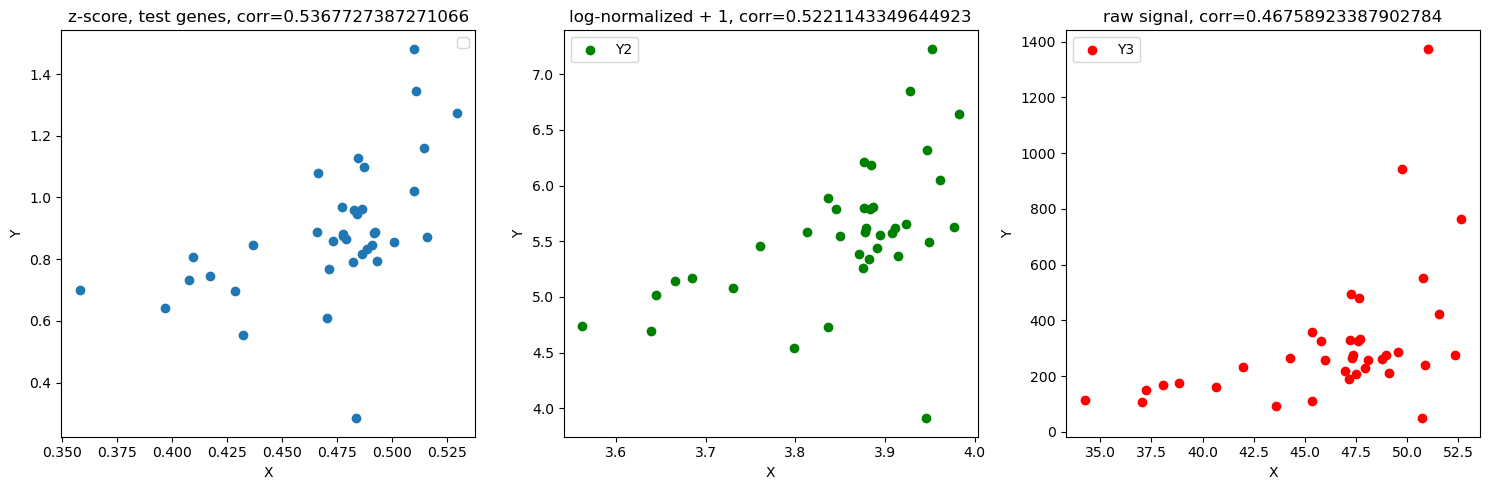

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


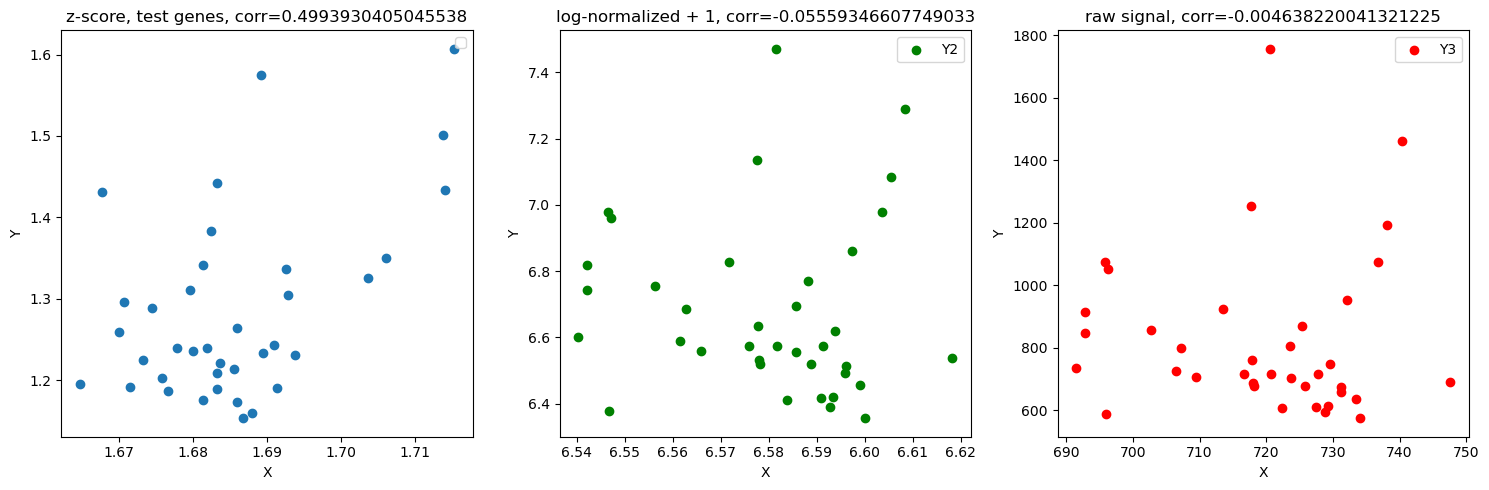

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


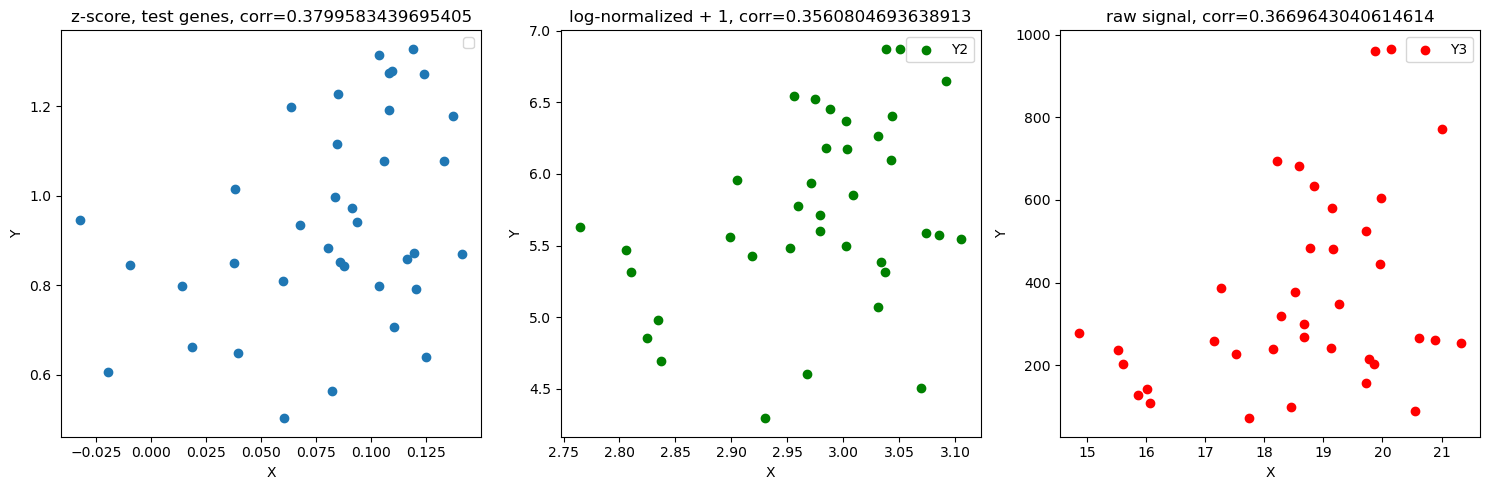

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


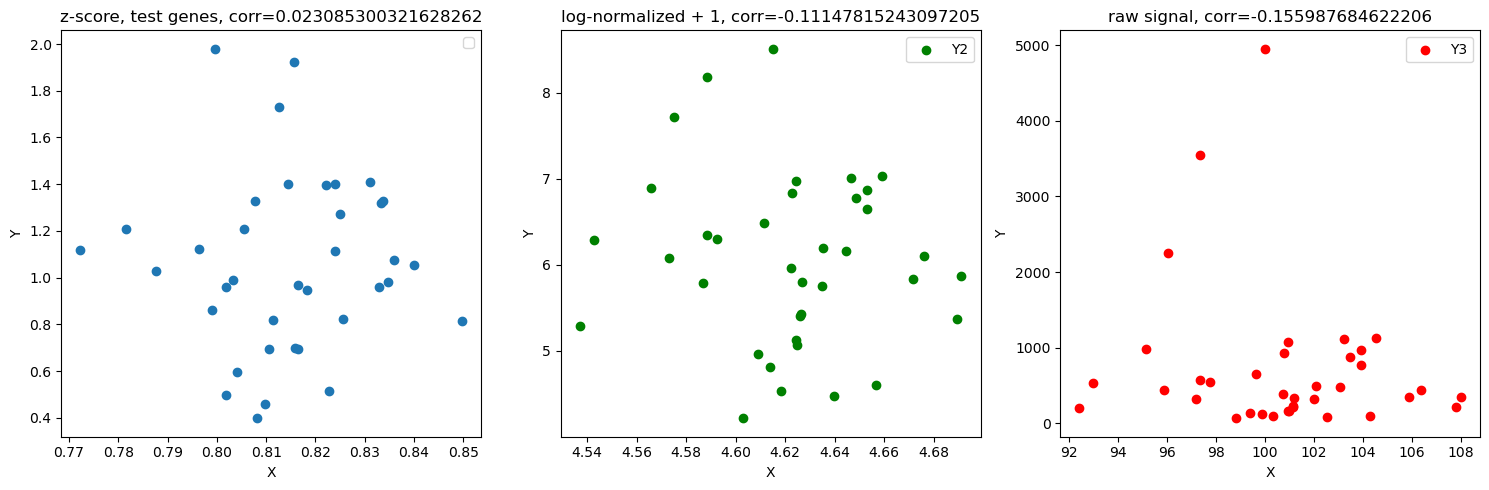

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


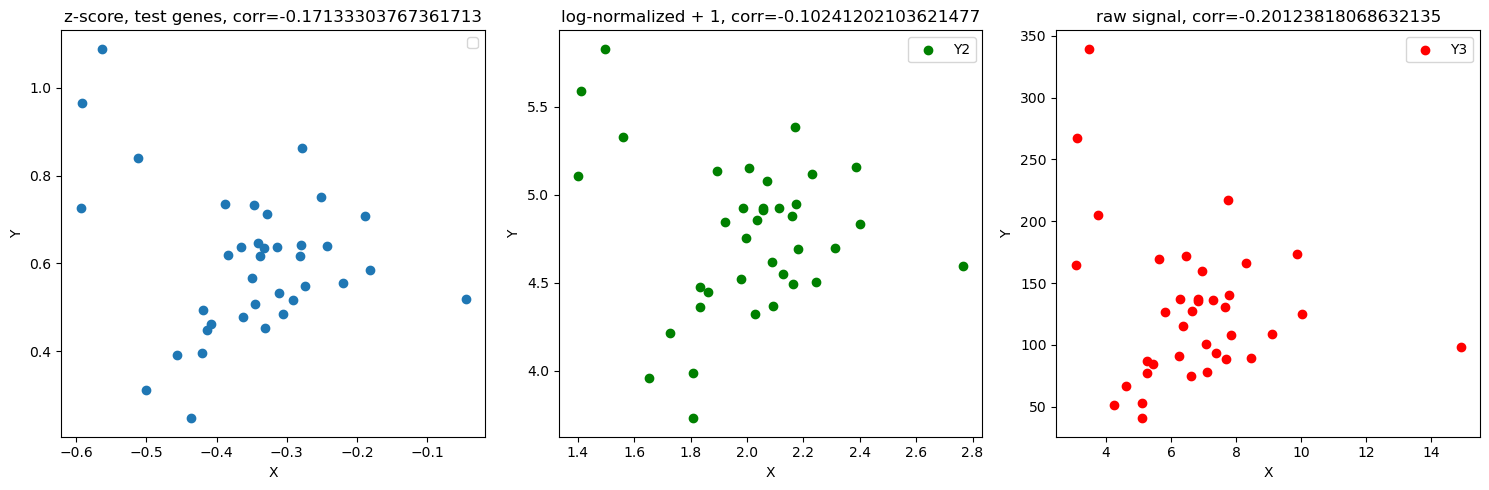

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


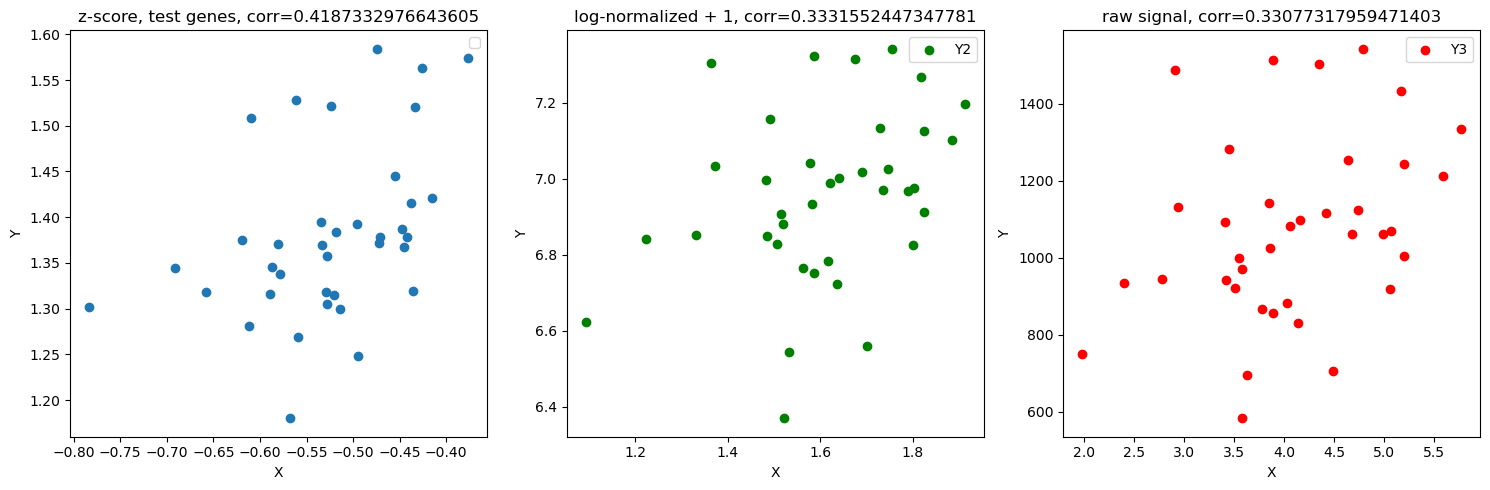

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


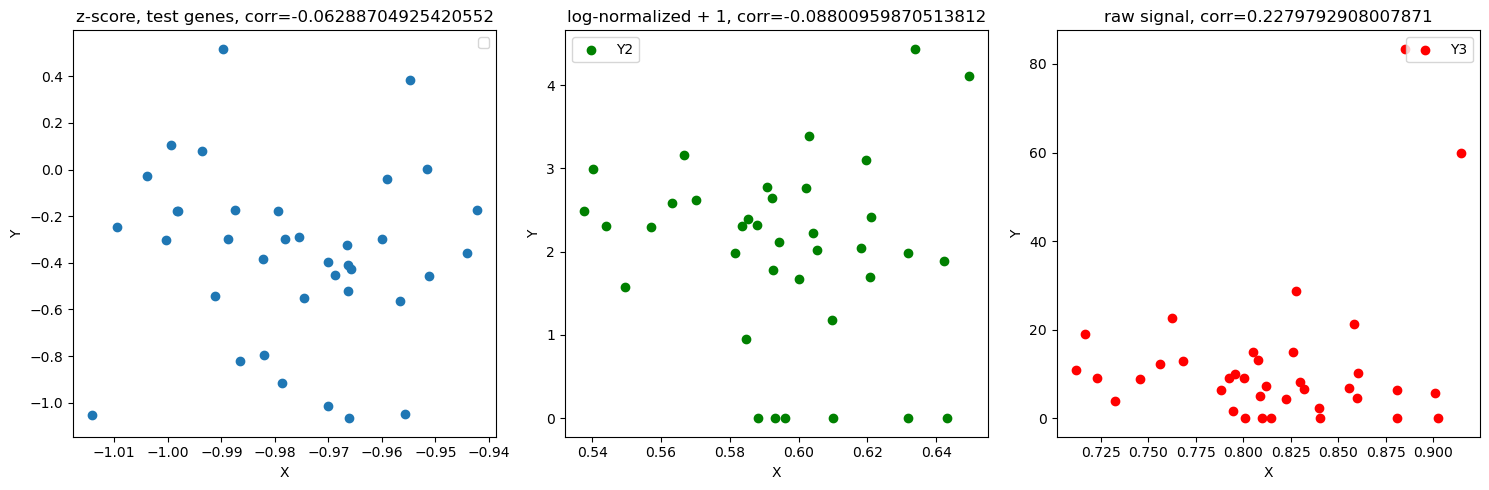

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


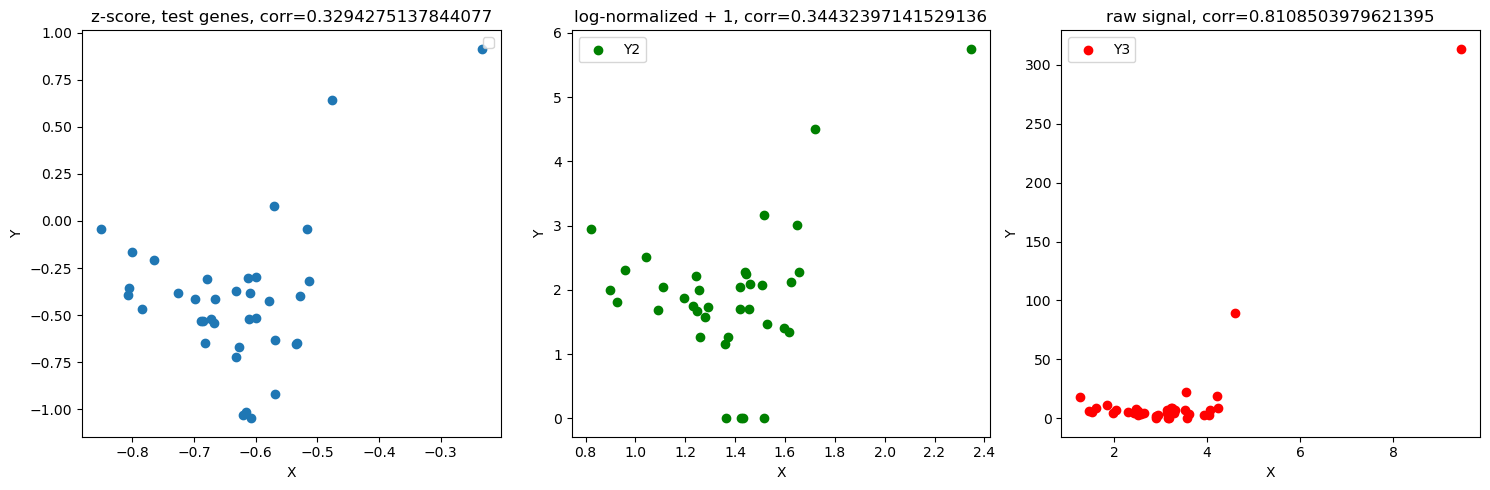

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


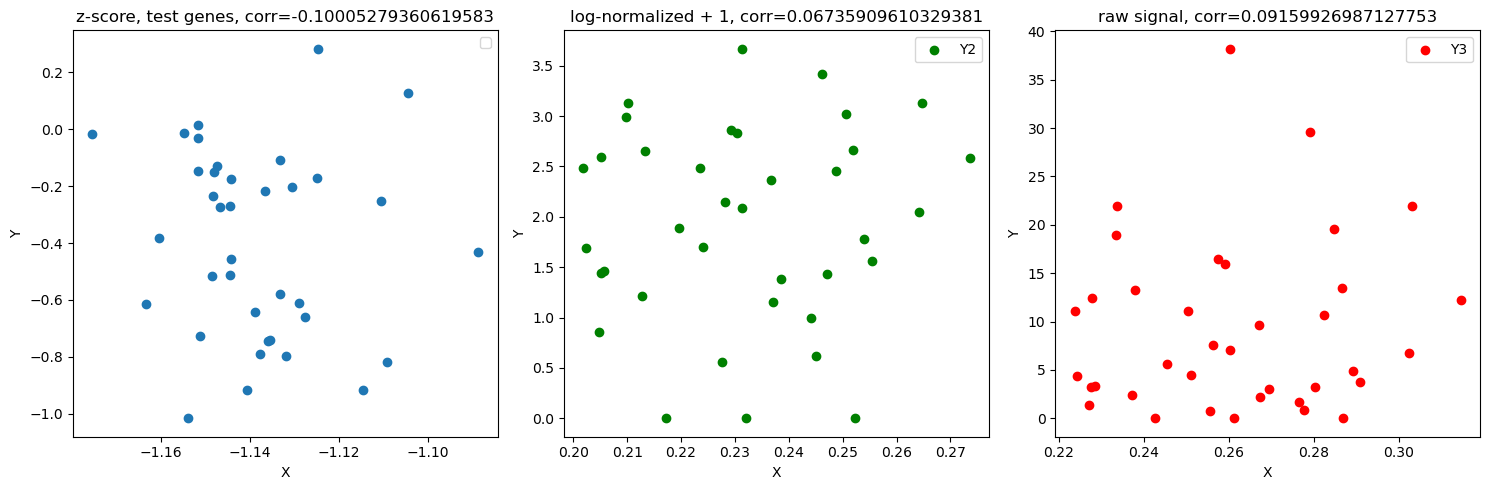

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


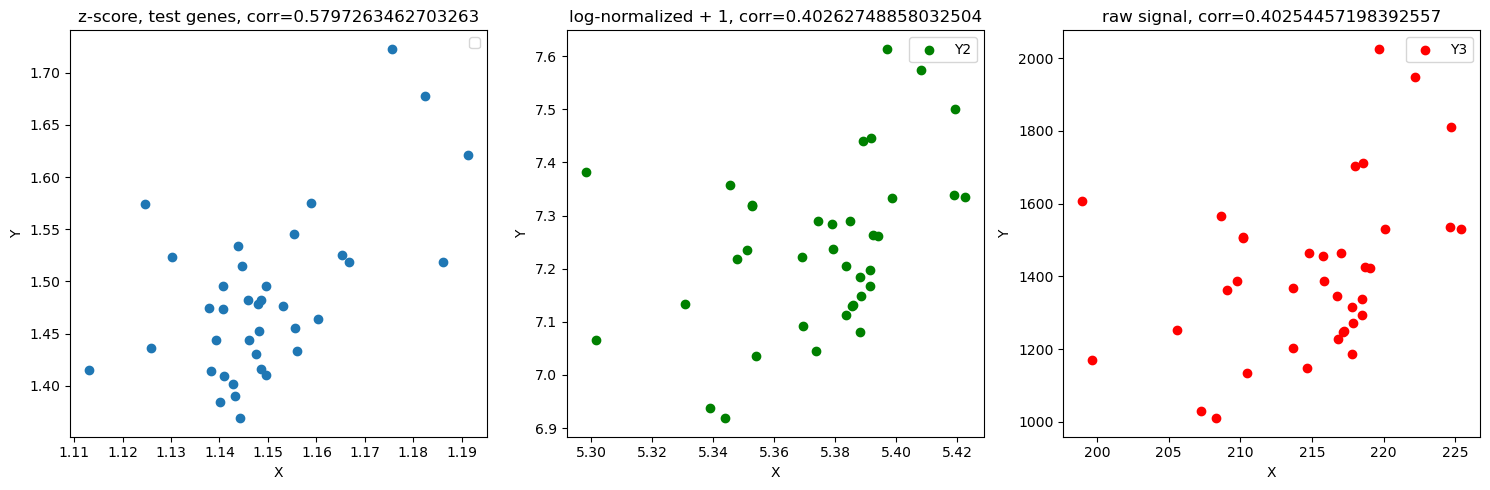

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


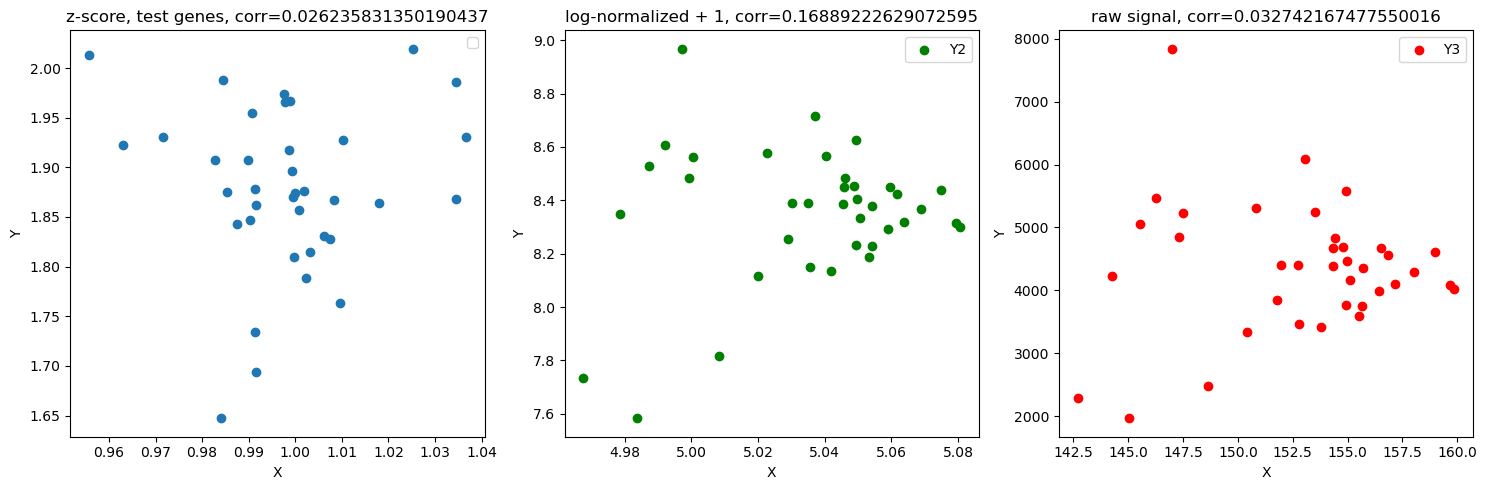

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


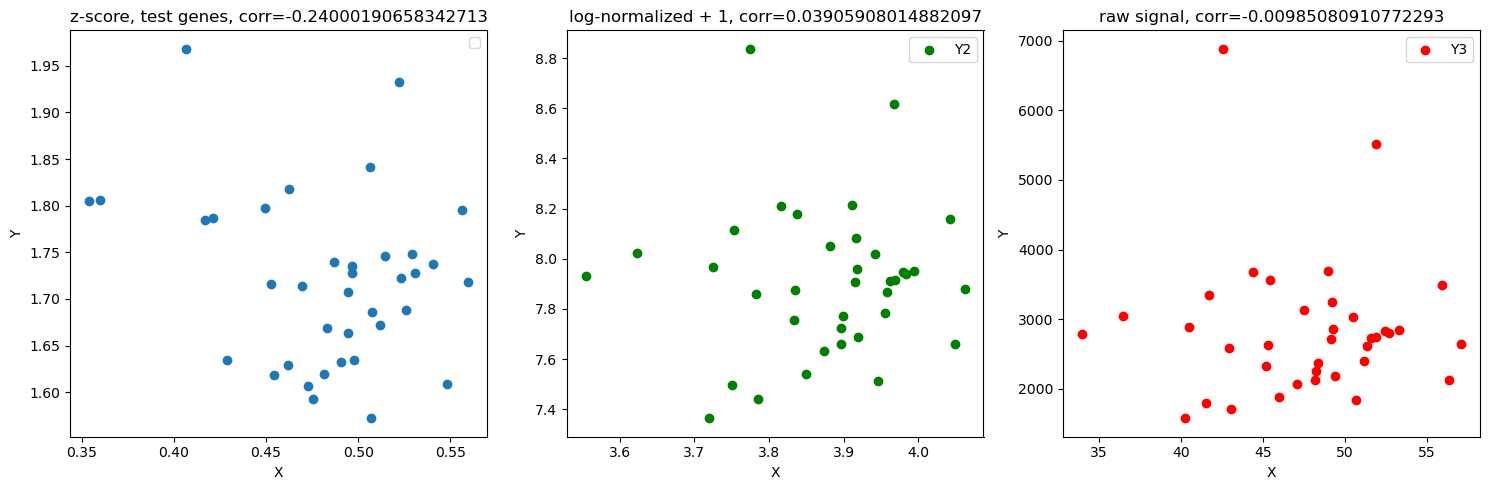

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


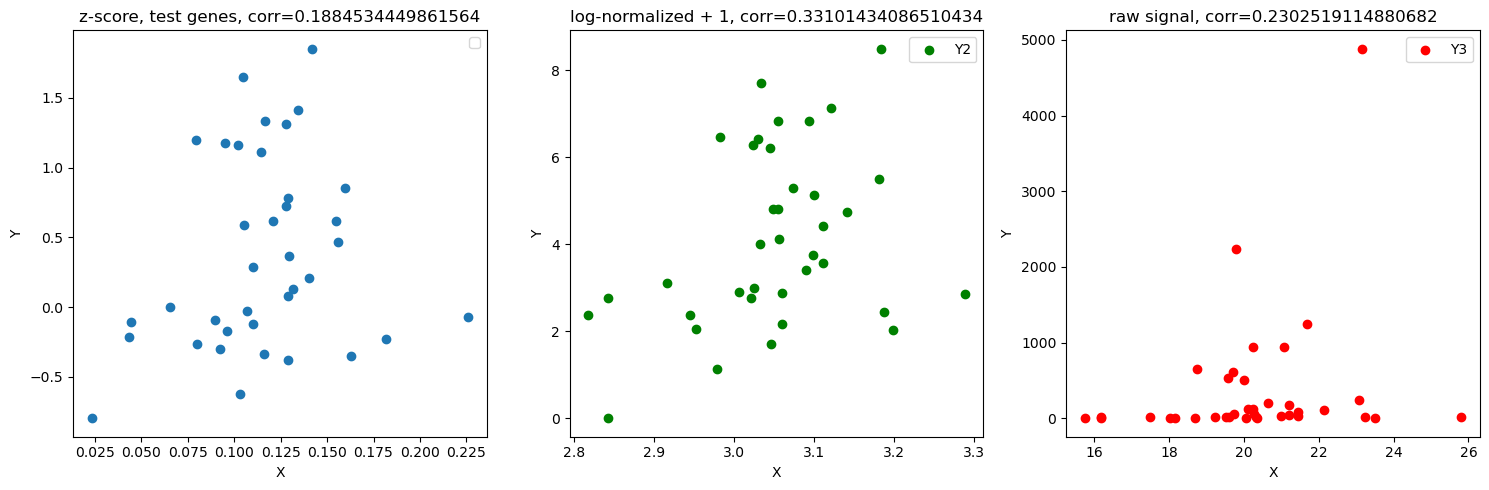

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


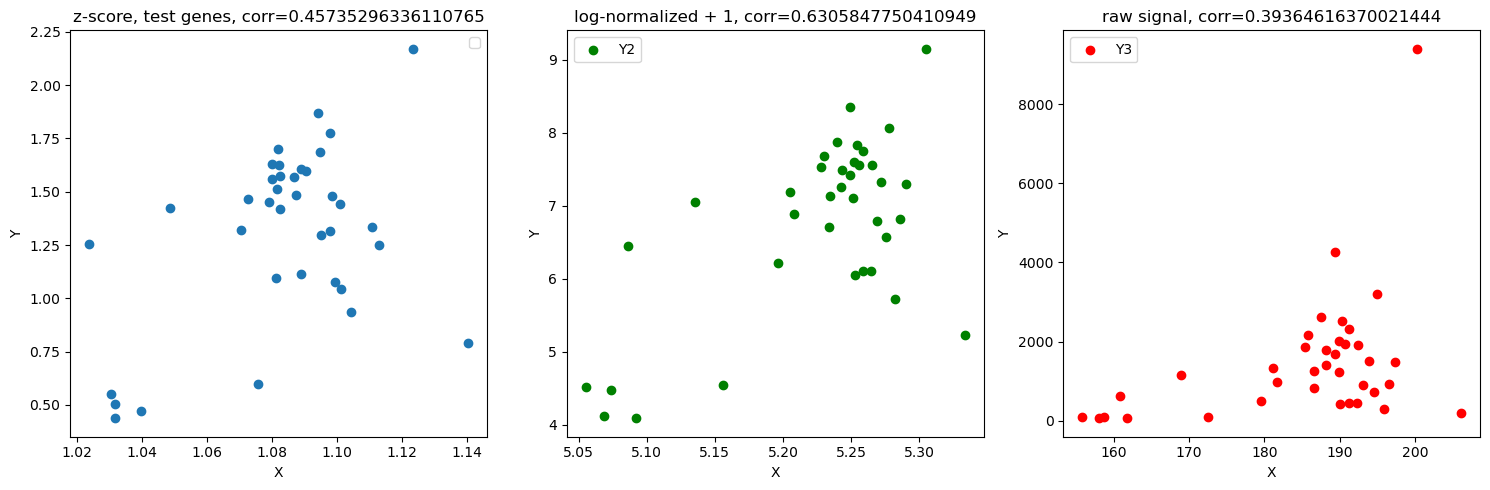

In [75]:

for i in range(40):

    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Scatterplot for the first subplot
    axes[0].scatter(a[i,:], b[i,:])
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].set_title(f'z-score, test genes, corr={np.corrcoef(a[i, :],b[i, :])[0,1]}')
    axes[0].legend()

    # Scatterplot for the second subplot
    axes[1].scatter(a_log[i,:], b_log[i,:], color='g', label='Y2')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].set_title(f'log-normalized + 1, corr={np.corrcoef(a_log[i, :], b_log[i, :])[0,1]}')
    axes[1].legend()

    # Scatterplot for the third subplot
    axes[2].scatter(a_raw[i,:], b_raw[i,:], color='r', label='Y3')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].set_title(f'raw signal, corr={np.corrcoef(a_raw[i, :], b_raw[i, :])[0,1]}')
    axes[2].legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


<Axes: >

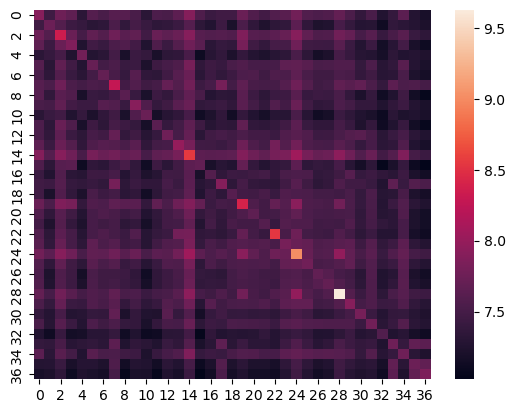

In [122]:
sns.heatmap(np.cov(np.log(count_mat +1)))

<Axes: >

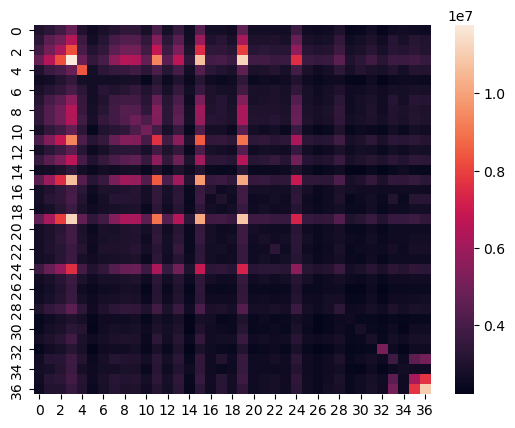

In [120]:
sns.heatmap(np.cov(count_mat))